# Extraction des entités nommées

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from utils.fonctions import (
    load_jnlpba_dataset, load_ncbi_dataset,prepare_ncbi_for_ner,create_embedding_matrix_from_word2vec,load_word2vec_model,save_word2vec_model,train_word2vec_embeddings
)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,create_tag_mapping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","cuda" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  cuda


## ÉTAPE 2: DATA PREPROCESSING

In [2]:
jnlpba_sentences, jnlpbaclasses = load_jnlpba_dataset("./datasets/JNLPBA")
print(jnlpba_sentences[1])

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- sentences: 22402 phrases
- 11 Classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
[('Activation', 'O'), ('of', 'O'), ('the', 'O'), ('CD28', 'B-protein'), ('surface', 'I-protein'), ('receptor', 'I-protein'), ('provides', 'O'), ('a', 'O'), ('major', 'O'), ('costimulatory', 'O'), ('signal', 'O'), ('for', 'O'), ('T', 'O'), ('cell', 'O'), ('activation', 'O'), ('resulting', 'O'), ('in', 'O'), ('enhanced', 'O'), ('production', 'O'), ('of', 'O'), ('interleukin-2', 'B-protein'), ('(', 'O'), ('IL-2', 'B-protein'), (')', 'O'), ('and', 'O'), ('cell', 'O'), ('proliferation', 'O'), ('.', 'O')]


In [3]:
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(ncbi_sentences[1])

Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus
Documents chargés: 793
Exemple d'entités dans le premier document: 2
(['However', ',', 'the', 'function', 'of', 'the', 'BRCA1', 'protein', 'has', 'remained', 'elusive', '.'], ['I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'O', 'O', 'O', 'O', 'O'])


Création de dataset JNLPBA

In [4]:
def create_jnlpba_dataloaders(jnlpba_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """ 
    Crée les Dataloaders avec Word2Vec
    """ 
    # 1. Créer les vocabulaires
    vocab = create_vocab(jnlpba_sentences, min_freq=2)
    char_vocab = create_char_vocab(jnlpba_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(jnlpba_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(jnlpba_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = jnlpba_sentences[:train_size]
    dev_sentences = jnlpba_sentences[train_size:train_size + dev_size]
    test_sentences = jnlpba_sentences[train_size + dev_size:]
    
    print(f"JNLPBA - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    word2vec_model = None
    
    if word2vec_path:
        print(f"Tentative de chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    
    if word2vec_model is None:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        
        # Extraire les phrases pour Word2Vec
        tokenized_sentences = [
        [token.lower() for token, label in sentence]
        for sentence in jnlpba_sentences
    ]
            
        
        print(f"Nombre de phrases pour Word2Vec: {len(tokenized_sentences)}")
        print(f"Exemple: {tokenized_sentences[0][:10]}")
        
        # Entraîner Word2Vec
        from gensim.models import Word2Vec
        word2vec_model = Word2Vec(
            sentences=tokenized_sentences,
            vector_size=200,
            window=5,
            min_count=2,
            workers=4,
            sg=1,  # Skip-gram
            epochs=10
        )
        
        print(f"Vocabulaire Word2Vec entraîné: {len(word2vec_model.wv)} mots")
        
        # Sauvegarder le modèle
        if word2vec_path:
            try:
                save_word2vec_model(word2vec_model, word2vec_path)
            except Exception as e:
                print(f"Attention: impossible de sauvegarder le modèle: {e}")
                print("Le modèle sera utilisé en mémoire seulement.")
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }

BATCH_SIZE = 32
results_jnlpba = create_jnlpba_dataloaders(jnlpba_sentences,batch_size=BATCH_SIZE,word2vec_path="./word2Vecembeddings/jnlpba_word2vec")

Format vocab: Liste de paires (token, label)
Vocabulaire créé: 12664 mots
Mots uniques: 22678
Mots avec fréquence >= 2: 12661
Format char vocab: Liste de paires (token, label)
Vocabulaire caractères créé: 85 caractères
Caractères uniques: 83
Format tag mapping: Liste de paires (token, label)
Mapping tags créé: 12 tags uniques
Tags: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']
JNLPBA - Train: 15681, Dev: 3360, Test: 3361
Tentative de chargement du modèle Word2Vec depuis: ./word2Vecembeddings/jnlpba_word2vec
Modèle Word2Vec chargé: ./word2Vecembeddings/jnlpba_word2vec
Mots trouvés dans Word2Vec: 12661
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 15681 phrases valides
Dataset créé: 3360 phrases valides
Dataset créé: 3361 phrases valides


In [5]:
train_loader = results_jnlpba['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_jnlpba['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_jnlpba['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([28, 12, 12, 23, 20, 57,  8, 12, 35, 46, 15, 15, 56, 11, 16, 44, 19, 22,
        21, 46, 27, 21, 35, 12, 24, 17, 42, 19, 30, 24, 48, 15])

Premier exemple du batch:
Word IDs : tensor([  32,   20,  697, 1398,   68,   40,  315,   42,    1,  709,   19, 2801,
        3167,   32,   96,   29,  105,  111,  112,  113,  532,  533,  727,   19,
         169, 1176,   64,   18,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

In [6]:
def create_ncbi_dataloaders(ncbi_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """
    Crée les DataLoaders pour NCBI avec Word2Vec
    """
    # 1. Créer les vocabulaires
    vocab = create_vocab(ncbi_sentences, min_freq=2)
    char_vocab = create_char_vocab(ncbi_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(ncbi_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(ncbi_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = ncbi_sentences[:train_size]
    dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
    test_sentences = ncbi_sentences[train_size + dev_size:]
    
    print(f"NCBI - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    if word2vec_path and os.path.exists(word2vec_path):
        print(f"Chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    else:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        # Entraîner sur toutes les données
        word2vec_model = train_word2vec_embeddings(ncbi_sentences)
        
        # Sauvegarder le modèle
        if word2vec_path:
            save_word2vec_model(word2vec_model, word2vec_path)
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }
    
results_ncbi = ncbi_data_loaders = create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=BATCH_SIZE,
    word2vec_path="./word2Vecembeddings/ncbi"
)

Format vocab: Tuple (tokens, labels)
Vocabulaire créé: 5925 mots
Mots uniques: 10845
Mots avec fréquence >= 2: 5922
Format char vocab: Tuple (tokens, labels)
Vocabulaire caractères créé: 86 caractères
Caractères uniques: 84
Format tag mapping: Tuple (tokens, labels)
Mapping tags créé: 10 tags uniques
Tags: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']
NCBI - Train: 5266, Dev: 1128, Test: 1130
Entraînement d'un nouveau modèle Word2Vec...
Nombre de phrases pour Word2Vec: 7524
Première phrase: ['germline', 'mutations', 'in', 'brca1', 'are', 'responsible', 'for', 'most', 'cases', 'of']...
Entraînement du modèle Word2Vec...
Vocabulaire Word2Vec: 5922 mots
Taille des vecteurs: 200
Modèle Word2Vec sauvegardé: ./word2Vecembeddings/ncbi.model
Mots trouvés dans Word2Vec: 5922
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 5266 phrases valides
Dataset créé: 1128 phrases valides
Dat

In [7]:
train_loader = results_ncbi['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_ncbi['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_ncbi['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([45, 19, 22, 30, 22,  9, 33, 38, 21, 28,  5, 25, 24, 23, 21,  1, 36, 29,
        21, 18,  4, 23, 34, 24, 15,  9, 29,  2, 21, 72, 18, 16])

Premier exemple du batch:
Word IDs : tensor([  21, 3575, 2414,  657,   48, 1786,    1,   20,  180,   24,  260,  766,
          66,   38,  162,   21,   10,  149,   75,    5, 3069,  288,   76,    1,
          84,    1,   84,   80,   20,  139,   43,  227,   62,   21,   10,  149,
          75,    5, 1166,  288,   76,    1,   84,   80,   18,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

Model architecture

In [8]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)
        optimizer.zero_grad()
        # Passer les tags -> forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, idx_to_tag):
    """
    Evaluate model (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss (tags fournis)
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list
            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor -> numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculate precision, recall, F1-score
    """
    from sklearn.metrics import precision_recall_fscore_support
    
    # Filter out 'O' tags for entity-specific metrics
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


JNLPBA Dataset

In [ ]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    embedding_url: str = None,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 40,
    patience: int = 4,   
    checkpoints_dir="./checkpoints",
):
    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']

    comb_name = "WE"
    if use_char_cnn and use_char_lstm:
        comb_name += "_char_bilstm_cnn"
    elif use_char_cnn:
        comb_name += "_char_cnn"
    elif use_char_lstm:
        comb_name += "_char_bilstm"

    if use_attention:
        comb_name += "_attention"
    if use_fc_fusion:
        comb_name += "_fc"

    checkpoints_path = f"{checkpoints_dir}/{comb_name}/best_model.pt"
    os.makedirs(os.path.dirname(checkpoints_path), exist_ok=True)

    # Chargement des embeddings
    if embedding_url:
        pretrained_embeddings = load_word2vec_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        pretrained_embeddings = loaders['pretrained_embeddings']
    else:
        print("Embedding nul")
        return

    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        dataset=dataset_name,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Adam optimizer avec L2 / weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Scheduler manuel: decay rate selon dataset
    decay_rate = 0.90 if dataset_name == 'JNLPBA' else 0.95

    best_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [], 'dev_loss': [], 'dev_f1': [],
        'dev_precision': [], 'dev_recall': [], 'lr': []
    }

    for epoch in range(epochs):
        # 1. Train
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # 2. Eval
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)

        # 3. Appliquer decay rate
        for g in optimizer.param_groups:
            g['lr'] *= decay_rate

        # 4. Historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['dev_precision'].append(precision)
        history['dev_recall'].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # 5. Early stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé: F1 {f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered après {epoch+1} epochs.")
            break

    # Charger meilleur modèle
    checkpoint = torch.load(checkpoints_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_preds, test_targets = evaluate(model, test_loader, device, idx_to_tag)
    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)

    return model, history


Cobinaison WE

In [ ]:
model_jnlpba_we, history_jnlpba_we = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 2,873,972


Training: 100%|██████████| 491/491 [02:19<00:00,  3.53it/s]


Epoch 01/40 | Train loss: 333.1563 | Dev loss: 183.1744 | P: 0.7193 R: 0.6350 F1: 0.6685 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6685


Training: 100%|██████████| 491/491 [02:01<00:00,  4.04it/s]


Epoch 02/40 | Train loss: 134.6183 | Dev loss: 157.5923 | P: 0.7332 R: 0.6623 F1: 0.6856 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.6856


Training: 100%|██████████| 491/491 [01:46<00:00,  4.63it/s]


Epoch 03/40 | Train loss: 102.3548 | Dev loss: 140.4697 | P: 0.7335 R: 0.6707 F1: 0.6943 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.6943


Training: 100%|██████████| 491/491 [01:40<00:00,  4.86it/s]


Epoch 04/40 | Train loss: 84.0082 | Dev loss: 135.7874 | P: 0.7393 R: 0.7014 F1: 0.7185 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7185


Training: 100%|██████████| 491/491 [01:43<00:00,  4.76it/s]


In [11]:
import torch
from torchsummary import summary

def show_model_architecture(model: torch.nn.Module, device: str = "cpu", loaders=None):
    if loaders is None:
        raise ValueError("Le dictionnaire de loaders doit être fourni.")
    
    train_loader = loaders['train_loader']
    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']
    
    model.to(device)
    print(model)  
    batch = next(iter(train_loader))
    word_ids, char_seqs, tag_ids, lengths = batch
    word_ids = word_ids.to(device)
    char_seqs = char_seqs.to(device) if char_seqs is not None else None
    mask = (word_ids != 0)
    try:
        if char_seqs is not None:
            summary(model, [(word_ids.shape[1],), (char_seqs.shape[1], char_seqs.shape[2])])
        else:
            summary(model, [(word_ids.shape[1],)])
    except Exception as e:
        print("Impossible d'utiliser torchsummary:", e)

In [12]:
show_model_architecture(model_jnlpba_we, device="cpu", loaders=results_jnlpba)

CombinatorialNER(
  (word_embedding): Embedding(12664, 200, padding_idx=0)
  (context_lstm): LSTM(200, 128, batch_first=True, bidirectional=True)
  (emission): Linear(in_features=256, out_features=12, bias=True)
  (crf): CRF(num_tags=12)
)
Impossible d'utiliser torchsummary: CombinatorialNER.forward() missing 1 required positional argument: 'mask'


In [37]:
import pickle
import os

def save_vocabularies(data_dict, save_dir):
    """Sauvegarde les vocabulaires et mappings"""
    os.makedirs(save_dir, exist_ok=True)
    
    with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['vocab'], f)
    
    with open(os.path.join(save_dir, 'char_vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['char_vocab'], f)
    
    with open(os.path.join(save_dir, 'tag_to_idx.pkl'), 'wb') as f:
        pickle.dump(data_dict['tag_to_idx'], f)
    
    with open(os.path.join(save_dir, 'idx_to_tag.pkl'), 'wb') as f:
        pickle.dump(data_dict['idx_to_tag'], f)
    
    print(f"Vocabulaires sauvegardés dans {save_dir}")
    
save_vocabularies(results_jnlpba, './vocab/jnlpba')

Vocabulaires sauvegardés dans ./vocab/jnlpba


In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1 (double axis)
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2)

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


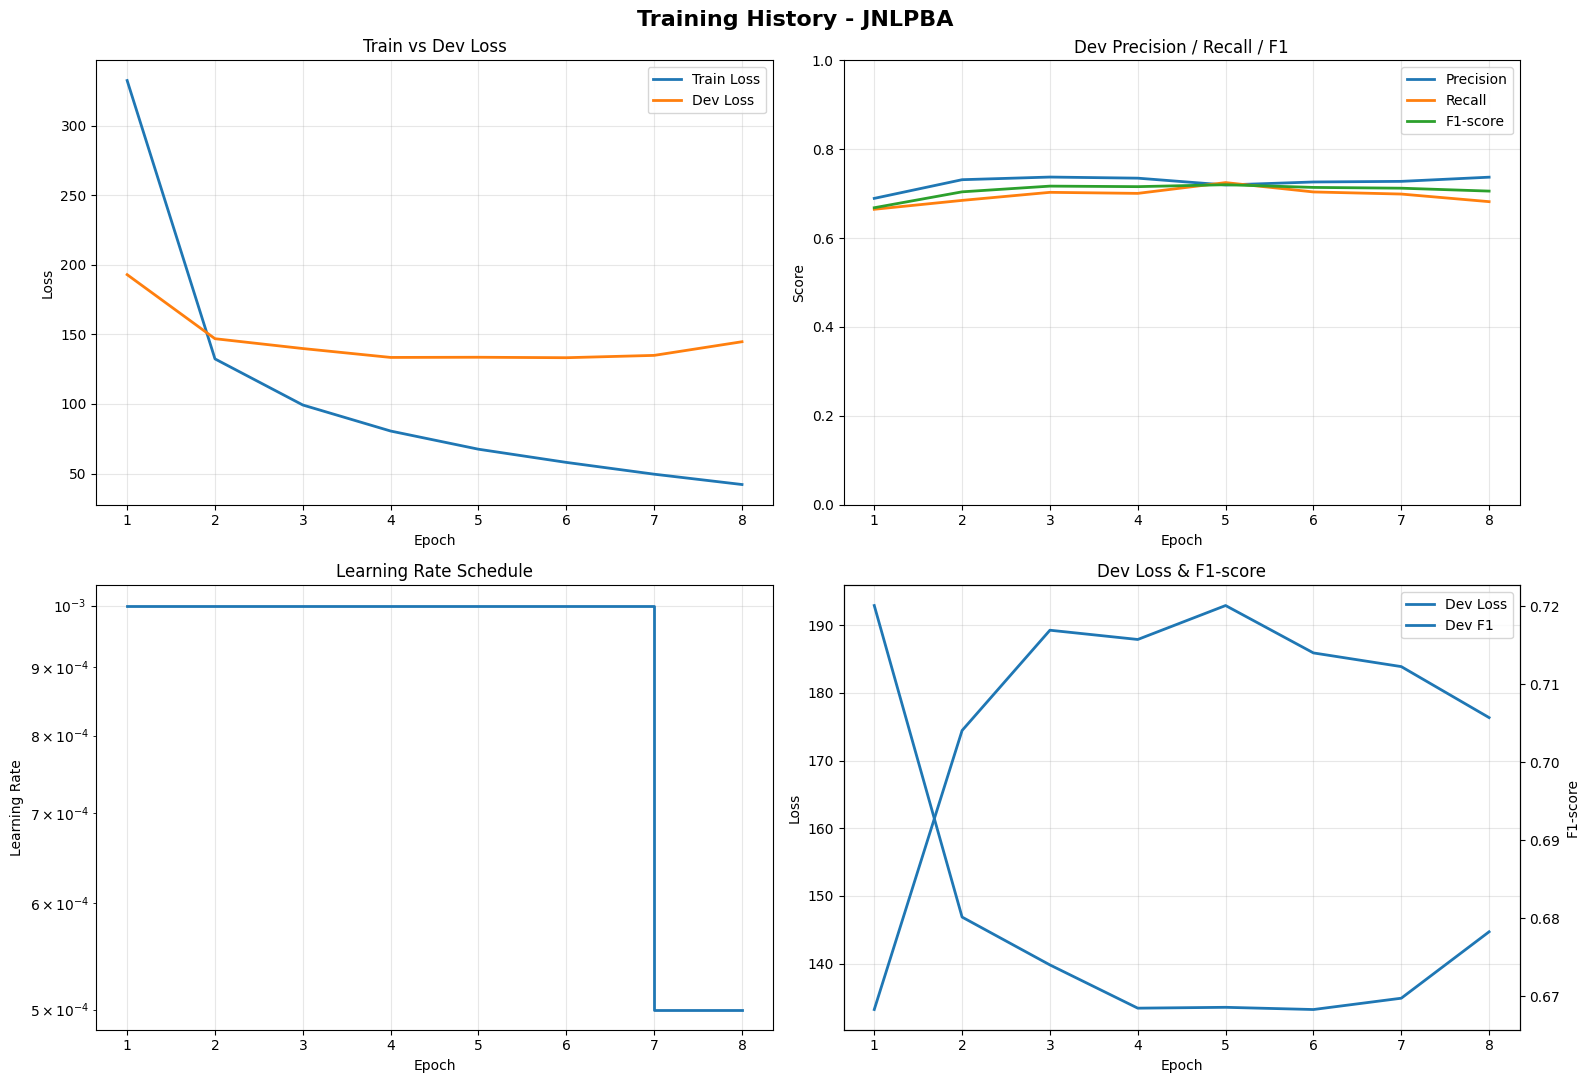


STATISTIQUES FINALES - JNLPBA
Meilleur F1 (dev)       : 0.7201
Meilleure Precision(dev): 0.7373
Meilleur Recall (dev)   : 0.7249
Final train loss        : 42.1167
Final dev loss          : 144.7084
Final learning rate     : 0.000500


In [14]:
plot_training_history(history_jnlpba_we, dataset_name="JNLPBA")

In [27]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=use_char_cnn,       
    use_char_lstm=use_char_lstm,      
    use_attention=use_attention,     
    use_fc_fusion=use_fc_fusion,  
    pretrained_embeddings=None,  
    word_embed_dim=200,
    lstm_hidden_dim=lstm_hidden,
    dropout=0.5
).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag

def plot_confusion_matrix_by_class(predictions, targets, idx_to_tag, dataset_name, 
                                   normalize=True, figsize=(12, 10),title="Matrice de confusion"):
    """
    Affiche la matrice de confusion par classe avec des statistiques détaillées
    """
    # Vérification des types
    print(f"\nVérification des types:")
    print(f"  Type predictions[0]: {type(predictions[0])}, valeur: {predictions[0]}")
    print(f"  Type targets[0]: {type(targets[0])}, valeur: {targets[0]}")
    
    # S'assurer que tout est string
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]
    
    # Filtrer les tags 'O' pour se concentrer sur les entités
    entity_predictions = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O':  
            entity_predictions.append(pred)
            entity_targets.append(target)
    
    print(f"\nStatistiques:")
    print(f"  Total tokens: {len(predictions)}")
    print(f"  Entity tokens: {len(entity_targets)}")
    print(f"  Unique entity tags in targets: {set(entity_targets)}")
    print(f"  Unique entity tags in predictions: {set(entity_predictions)}")
    
    # Obtenir les classes uniques (sauf 'O')
    all_unique_tags = sorted(set(entity_targets + entity_predictions))
    
    # Filtrer pour garder seulement les tags valides (pas les nombres)
    valid_tags = [tag for tag in all_unique_tags if not tag.isdigit()]
    
    # Si on a des tags numériques, c'est qu'il y a un problème de conversion
    numeric_tags = [tag for tag in all_unique_tags if tag.isdigit()]
    if numeric_tags:
        print(f"\nATTENTION: Tags numériques trouvés: {numeric_tags}")
        print("Cela indique que les prédictions sont des indices, pas des tags!")
        print(f"Mapping idx_to_tag: {dict(list(idx_to_tag.items())[:10])}")
    
    print(f"  Tags valides à plotter: {valid_tags}")
    
    if not valid_tags:
        print("Aucune entité valide trouvée dans les données!")
        return

    cm = confusion_matrix(entity_targets, entity_predictions, labels=valid_tags)
    supports = cm.sum(axis=1)  
    
    if normalize:
        # Éviter la division par zéro
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = cm.astype('float') / supports[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)
        cm_to_plot = cm_normalized
        fmt = '.2f'
        title_suffix = '(Normalisée)'
    else:
        cm_to_plot = cm
        fmt = 'd'
        title_suffix = '(Absolue)'
    
    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Si la matrice est trop grande, ajuster la taille
    if len(valid_tags) > 15:
        figsize = (max(12, len(valid_tags)), max(10, len(valid_tags)))
        plt.figure(figsize=figsize)
    
    sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=valid_tags, yticklabels=valid_tags,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    
    plt.title(title,fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    filtered_targets = []
    filtered_preds = []
    
    for t, p in zip(entity_targets, entity_predictions):
        if t in valid_tags and p in valid_tags:
            filtered_targets.append(t)
            filtered_preds.append(p)
    
    if filtered_targets:
        report = classification_report(filtered_targets, filtered_preds, 
                                       labels=valid_tags, zero_division=0)
        print(report)
    else:
        print("Pas assez de données pour générer le rapport")
    
    for i, tag in enumerate(valid_tags):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        support = supports[i]
        
        # Éviter les divisions par zéro
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Support est déjà un entier (sum de la ligne)
        print(f"{tag:20s}: Precision={precision:.3f}, Recall={recall:.3f}, "
              f"F1={f1:.3f}, Support={int(support)}")

def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


In [31]:
model_path = "./checkpoints/JNLPBA/we/best_model.pt"
model, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions, targets = predict_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/we/best_model.pt
Best F1 enregistré: 0.7201
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                  correct
 


Accuracy globale: 0.9226

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


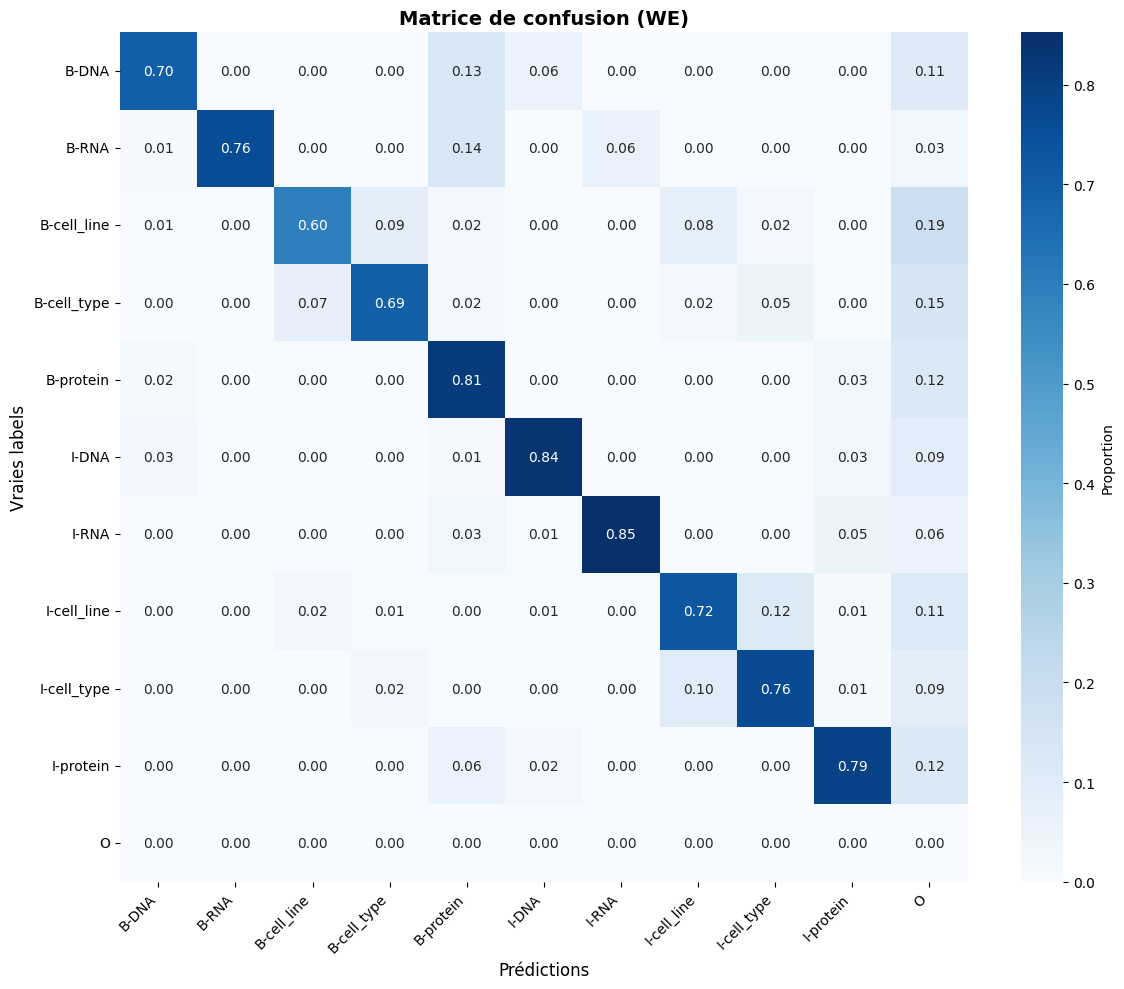

              precision    recall  f1-score   support

       B-DNA       0.84      0.70      0.76       855
       B-RNA       0.88      0.76      0.82        96
 B-cell_line       0.59      0.60      0.59       393
 B-cell_type       0.91      0.69      0.79      1729
   B-protein       0.89      0.81      0.85      4505
       I-DNA       0.89      0.84      0.86      1393
       I-RNA       0.88      0.85      0.86       156
 I-cell_line       0.61      0.72      0.66       792
 I-cell_type       0.92      0.76      0.83      2690
   I-protein       0.93      0.79      0.85      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.77     16829
   macro avg       0.76      0.68      0.72     16829
weighted avg       0.88      0.77      0.82     16829

B-DNA               : Precision=0.844, Recall=0.698, F1=0.764, Support=855
B-RNA               : Precision=0.880, Recall=0.760, F1=0.816, Support=96
B-cell_line         : Precision=0.588,

In [33]:
from sklearn.metrics import accuracy_score, classification_report

# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets, predictions)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions, targets) if t != 'O']
entity_targets = [t for p, t in zip(predictions, targets) if t != 'O']

if set(predictions) == set(targets) or all(isinstance(p, str) for p in predictions):
    plot_confusion_matrix_by_class(
        predictions=predictions,
        targets=targets,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets[:10])}")

La deuxième combinaison (“+ attention” sur WE)

In [ ]:
model_we_attention, history_we_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=8,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 2,940,020


Training: 100%|██████████| 491/491 [00:54<00:00,  9.06it/s]


Epoch 01/100 | Train loss: 778.4376 | Dev loss: 542.9260 | P: 0.0614 R: 0.1451 F1: 0.0863 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0863)


Training: 100%|██████████| 491/491 [00:54<00:00,  8.95it/s]


Epoch 02/100 | Train loss: 413.0732 | Dev loss: 396.1525 | P: 0.0699 R: 0.1313 F1: 0.0912 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0912)


Training: 100%|██████████| 491/491 [00:54<00:00,  8.96it/s]


Epoch 03/100 | Train loss: 327.4060 | Dev loss: 338.2606 | P: 0.0694 R: 0.1396 F1: 0.0925 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0925)


Training: 100%|██████████| 491/491 [00:54<00:00,  9.07it/s]


Epoch 04/100 | Train loss: 276.9034 | Dev loss: 310.3368 | P: 0.0709 R: 0.1351 F1: 0.0928 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0928)


Training: 100%|██████████| 491/491 [00:56<00:00,  8.63it/s]


Epoch 05/100 | Train loss: 243.8958 | Dev loss: 291.5817 | P: 0.0675 R: 0.1528 F1: 0.0894 | LR: 0.001000


Training: 100%|██████████| 491/491 [00:57<00:00,  8.57it/s]


Epoch 06/100 | Train loss: 219.6268 | Dev loss: 274.0306 | P: 0.0998 R: 0.1480 F1: 0.1037 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1037)


Training: 100%|██████████| 491/491 [00:56<00:00,  8.71it/s]


Epoch 07/100 | Train loss: 203.2566 | Dev loss: 262.3136 | P: 0.0944 R: 0.1535 F1: 0.1037 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1037)


Training: 100%|██████████| 491/491 [00:54<00:00,  8.99it/s]


Epoch 08/100 | Train loss: 187.8050 | Dev loss: 269.1876 | P: 0.2845 R: 0.1566 F1: 0.1320 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1320)


Training: 100%|██████████| 491/491 [00:56<00:00,  8.68it/s]


Epoch 09/100 | Train loss: 175.5997 | Dev loss: 251.7313 | P: 0.2276 R: 0.1950 F1: 0.1779 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1779)


Training: 100%|██████████| 491/491 [00:57<00:00,  8.61it/s]


Epoch 10/100 | Train loss: 164.9277 | Dev loss: 259.7585 | P: 0.2412 R: 0.2051 F1: 0.1903 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1903)


Training: 100%|██████████| 491/491 [00:55<00:00,  8.86it/s]


Epoch 11/100 | Train loss: 155.1598 | Dev loss: 255.3784 | P: 0.2475 R: 0.2171 F1: 0.2019 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2019)


Training: 100%|██████████| 491/491 [00:56<00:00,  8.73it/s]


Epoch 12/100 | Train loss: 146.0549 | Dev loss: 247.3337 | P: 0.2572 R: 0.2546 F1: 0.2333 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2333)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.22it/s]


Epoch 13/100 | Train loss: 138.0607 | Dev loss: 261.9432 | P: 0.2934 R: 0.2946 F1: 0.2829 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2829)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.61it/s]


Epoch 14/100 | Train loss: 131.7386 | Dev loss: 276.9652 | P: 0.3099 R: 0.2969 F1: 0.2864 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2864)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.64it/s]


Epoch 15/100 | Train loss: 124.6389 | Dev loss: 273.2889 | P: 0.3102 R: 0.3023 F1: 0.2805 | LR: 0.001000


Training: 100%|██████████| 491/491 [00:59<00:00,  8.21it/s]


Epoch 16/100 | Train loss: 118.3290 | Dev loss: 271.2538 | P: 0.2819 R: 0.3202 F1: 0.2794 | LR: 0.001000


Training: 100%|██████████| 491/491 [00:56<00:00,  8.74it/s]


Epoch 17/100 | Train loss: 113.0680 | Dev loss: 276.9062 | P: 0.3357 R: 0.3444 F1: 0.3136 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.3136)


Training: 100%|██████████| 491/491 [00:57<00:00,  8.54it/s]


Epoch 18/100 | Train loss: 105.8389 | Dev loss: 349.9161 | P: 0.3677 R: 0.3157 F1: 0.3122 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:08<00:00,  7.21it/s]


Epoch 19/100 | Train loss: 101.1075 | Dev loss: 308.6905 | P: 0.3835 R: 0.3599 F1: 0.3409 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.3409)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.78it/s]


Epoch 20/100 | Train loss: 95.5084 | Dev loss: 305.4774 | P: 0.3356 R: 0.3542 F1: 0.3174 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:02<00:00,  7.80it/s]


Epoch 21/100 | Train loss: 91.1155 | Dev loss: 347.3590 | P: 0.3716 R: 0.3444 F1: 0.3314 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:04<00:00,  7.62it/s]


Epoch 22/100 | Train loss: 85.2123 | Dev loss: 328.7841 | P: 0.4046 R: 0.3812 F1: 0.3569 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.3569)


Training: 100%|██████████| 491/491 [01:01<00:00,  8.01it/s]


Epoch 23/100 | Train loss: 79.5866 | Dev loss: 310.2427 | P: 0.4020 R: 0.4000 F1: 0.3878 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.3878)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.29it/s]


Epoch 24/100 | Train loss: 72.4271 | Dev loss: 326.4846 | P: 0.4279 R: 0.4269 F1: 0.4220 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.4220)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.18it/s]


Epoch 25/100 | Train loss: 65.2314 | Dev loss: 278.2999 | P: 0.5413 R: 0.4934 F1: 0.4845 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.4845)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.41it/s]


Epoch 26/100 | Train loss: 58.3460 | Dev loss: 277.0909 | P: 0.6164 R: 0.5515 F1: 0.5682 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.5682)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.33it/s]


Epoch 27/100 | Train loss: 53.2852 | Dev loss: 281.6787 | P: 0.6317 R: 0.5599 F1: 0.5695 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.5695)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.67it/s]


Epoch 28/100 | Train loss: 49.5777 | Dev loss: 303.8213 | P: 0.6664 R: 0.5508 F1: 0.5855 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.5855)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.98it/s]


Epoch 29/100 | Train loss: 44.1898 | Dev loss: 300.1318 | P: 0.6658 R: 0.5867 F1: 0.6162 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6162)


Training: 100%|██████████| 491/491 [00:53<00:00,  9.13it/s]


Epoch 30/100 | Train loss: 41.5152 | Dev loss: 306.9306 | P: 0.6763 R: 0.5916 F1: 0.6263 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6263)


Training: 100%|██████████| 491/491 [00:52<00:00,  9.28it/s]


Epoch 31/100 | Train loss: 37.7995 | Dev loss: 273.8837 | P: 0.6519 R: 0.6341 F1: 0.6392 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6392)


Training: 100%|██████████| 491/491 [00:54<00:00,  8.94it/s]


Epoch 32/100 | Train loss: 35.3290 | Dev loss: 308.8167 | P: 0.6795 R: 0.5906 F1: 0.6286 | LR: 0.001000


Training: 100%|██████████| 491/491 [00:54<00:00,  8.97it/s]


Epoch 33/100 | Train loss: 33.9056 | Dev loss: 303.8474 | P: 0.6789 R: 0.6075 F1: 0.6378 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:08<00:00,  7.13it/s]


Epoch 34/100 | Train loss: 31.9172 | Dev loss: 344.0558 | P: 0.6983 R: 0.5804 F1: 0.6294 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:05<00:00,  7.49it/s]


Epoch 35/100 | Train loss: 26.7778 | Dev loss: 300.4933 | P: 0.6780 R: 0.6204 F1: 0.6436 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6436)


Training: 100%|██████████| 491/491 [01:09<00:00,  7.12it/s]


Epoch 36/100 | Train loss: 23.4809 | Dev loss: 321.6883 | P: 0.6830 R: 0.6162 F1: 0.6440 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6440)


Training: 100%|██████████| 491/491 [01:05<00:00,  7.45it/s]


Epoch 37/100 | Train loss: 22.0293 | Dev loss: 339.4926 | P: 0.6729 R: 0.6161 F1: 0.6391 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:08<00:00,  7.14it/s]


Epoch 38/100 | Train loss: 21.1979 | Dev loss: 332.3923 | P: 0.6672 R: 0.6208 F1: 0.6396 | LR: 0.000500


Training: 100%|██████████| 491/491 [00:57<00:00,  8.50it/s]


Epoch 39/100 | Train loss: 20.5710 | Dev loss: 335.6800 | P: 0.6797 R: 0.6214 F1: 0.6454 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6454)


Training: 100%|██████████| 491/491 [00:56<00:00,  8.62it/s]


Epoch 40/100 | Train loss: 19.6754 | Dev loss: 362.1510 | P: 0.6864 R: 0.5952 F1: 0.6346 | LR: 0.000500


Training: 100%|██████████| 491/491 [00:56<00:00,  8.75it/s]


Epoch 41/100 | Train loss: 19.0753 | Dev loss: 332.2366 | P: 0.6904 R: 0.6140 F1: 0.6473 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6473)


Training: 100%|██████████| 491/491 [00:56<00:00,  8.66it/s]


Epoch 42/100 | Train loss: 18.2315 | Dev loss: 333.7845 | P: 0.6829 R: 0.6240 F1: 0.6490 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.6490)


Training: 100%|██████████| 491/491 [00:54<00:00,  9.09it/s]


Epoch 43/100 | Train loss: 17.5972 | Dev loss: 361.9331 | P: 0.6829 R: 0.6043 F1: 0.6383 | LR: 0.000500


Training: 100%|██████████| 491/491 [00:56<00:00,  8.64it/s]


Epoch 44/100 | Train loss: 16.4989 | Dev loss: 361.7074 | P: 0.6785 R: 0.6181 F1: 0.6438 | LR: 0.000500


Training: 100%|██████████| 491/491 [00:56<00:00,  8.63it/s]


Epoch 45/100 | Train loss: 15.7215 | Dev loss: 364.8738 | P: 0.6726 R: 0.6238 F1: 0.6440 | LR: 0.000250


Training: 100%|██████████| 491/491 [00:57<00:00,  8.55it/s]


Epoch 46/100 | Train loss: 14.0221 | Dev loss: 364.4652 | P: 0.6779 R: 0.6196 F1: 0.6443 | LR: 0.000250


Training: 100%|██████████| 491/491 [00:56<00:00,  8.62it/s]


Epoch 47/100 | Train loss: 12.8401 | Dev loss: 378.9223 | P: 0.6777 R: 0.6209 F1: 0.6452 | LR: 0.000250


Training: 100%|██████████| 491/491 [00:55<00:00,  8.77it/s]


Epoch 48/100 | Train loss: 12.3305 | Dev loss: 393.6294 | P: 0.6698 R: 0.6092 F1: 0.6356 | LR: 0.000125


Training: 100%|██████████| 491/491 [00:57<00:00,  8.53it/s]


Epoch 49/100 | Train loss: 11.6934 | Dev loss: 377.7882 | P: 0.6714 R: 0.6173 F1: 0.6410 | LR: 0.000125


Training: 100%|██████████| 491/491 [00:59<00:00,  8.30it/s]


Epoch 50/100 | Train loss: 11.3497 | Dev loss: 378.7934 | P: 0.6669 R: 0.6187 F1: 0.6397 | LR: 0.000125

Early stopping triggered après 50 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 384.3357
Precision: 0.5768
Recall: 0.5925
F1-score: 0.5805

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 34: LR = 0.000500
  Epoch 45: LR = 0.000250
  Epoch 48: LR = 0.000125


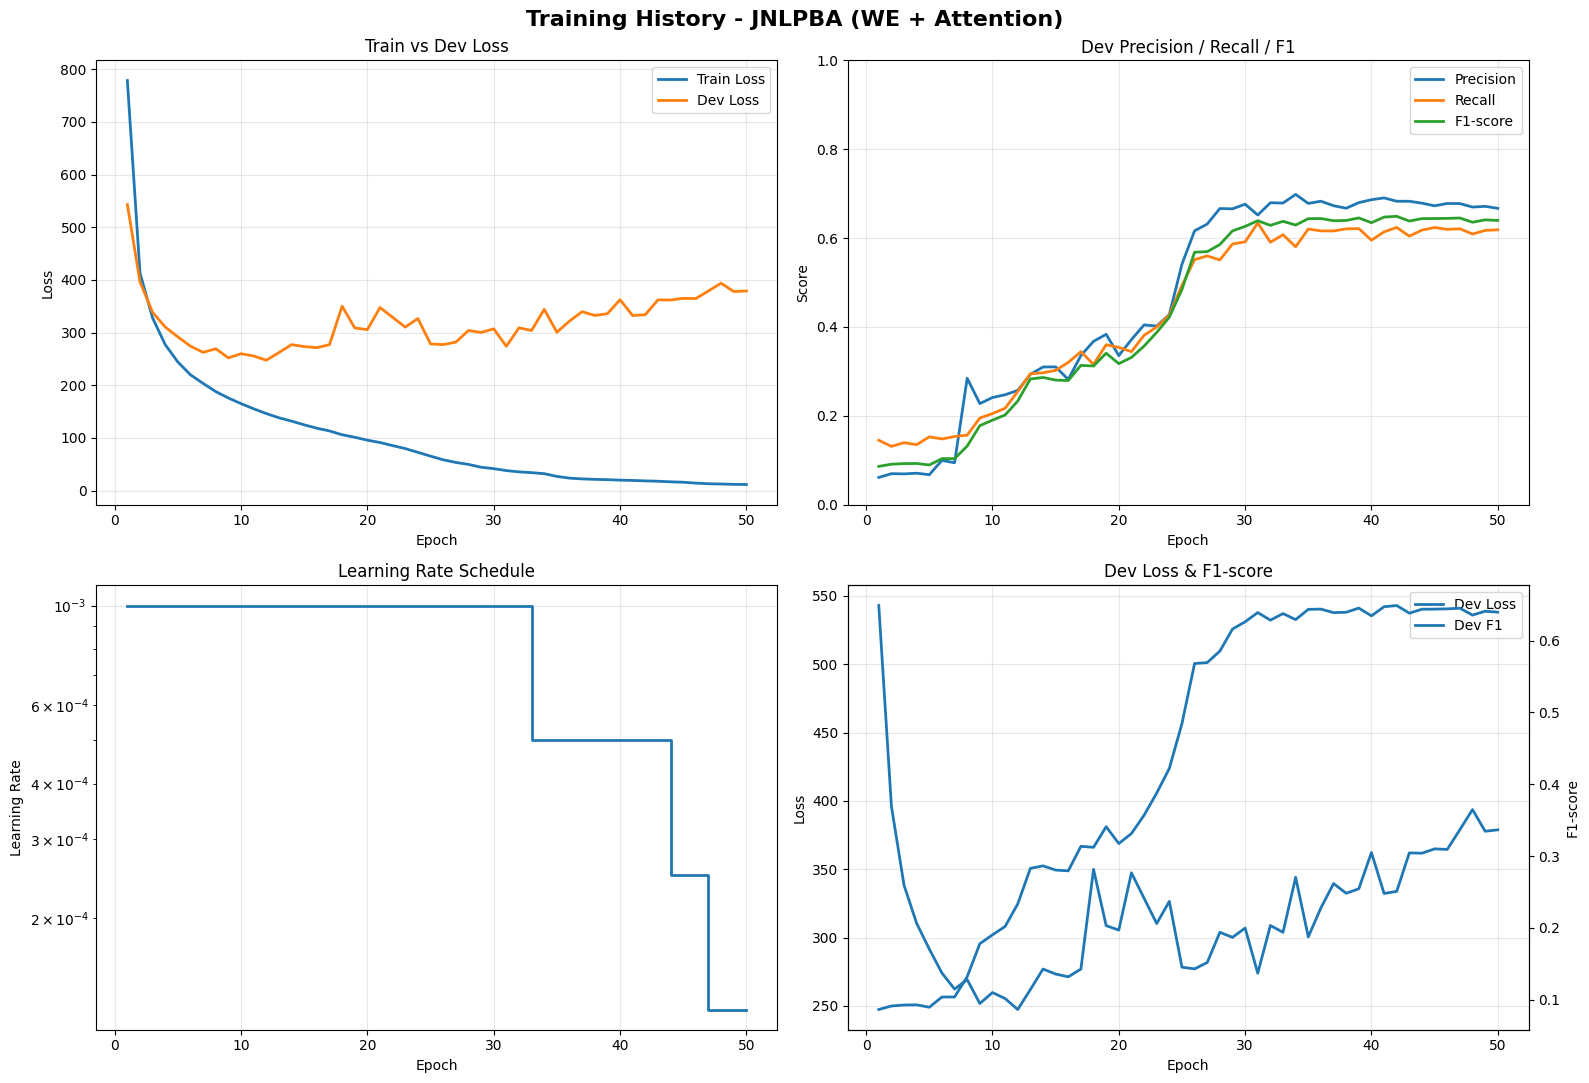


STATISTIQUES FINALES - JNLPBA (WE + Attention)
Meilleur F1 (dev)       : 0.6490
Meilleure Precision(dev): 0.6983
Meilleur Recall (dev)   : 0.6341
Final train loss        : 11.3497
Final dev loss          : 378.7934
Final learning rate     : 0.000125


In [14]:
plot_training_history(history_we_attention, dataset_name="JNLPBA (WE + Attention)")

In [15]:
model_path = "./checkpoints/JNLPBA/WE_attention/best_model.pt"
model_we_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions_we_attention, targets_we_attention = predict_on_test_set(
    model=model_we_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_attention/best_model.pt
Best F1 enregistré: 0.6490
Époque: 41
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_line        correct
  9 | I-cell_line        | I-cell_line        correct
 10 | I-cell_line        | I-cell_line        correct
 11 | I-cell_line        | I-cell_line        correct
 12 | O                  | O                  correc


Accuracy globale: 0.9005

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


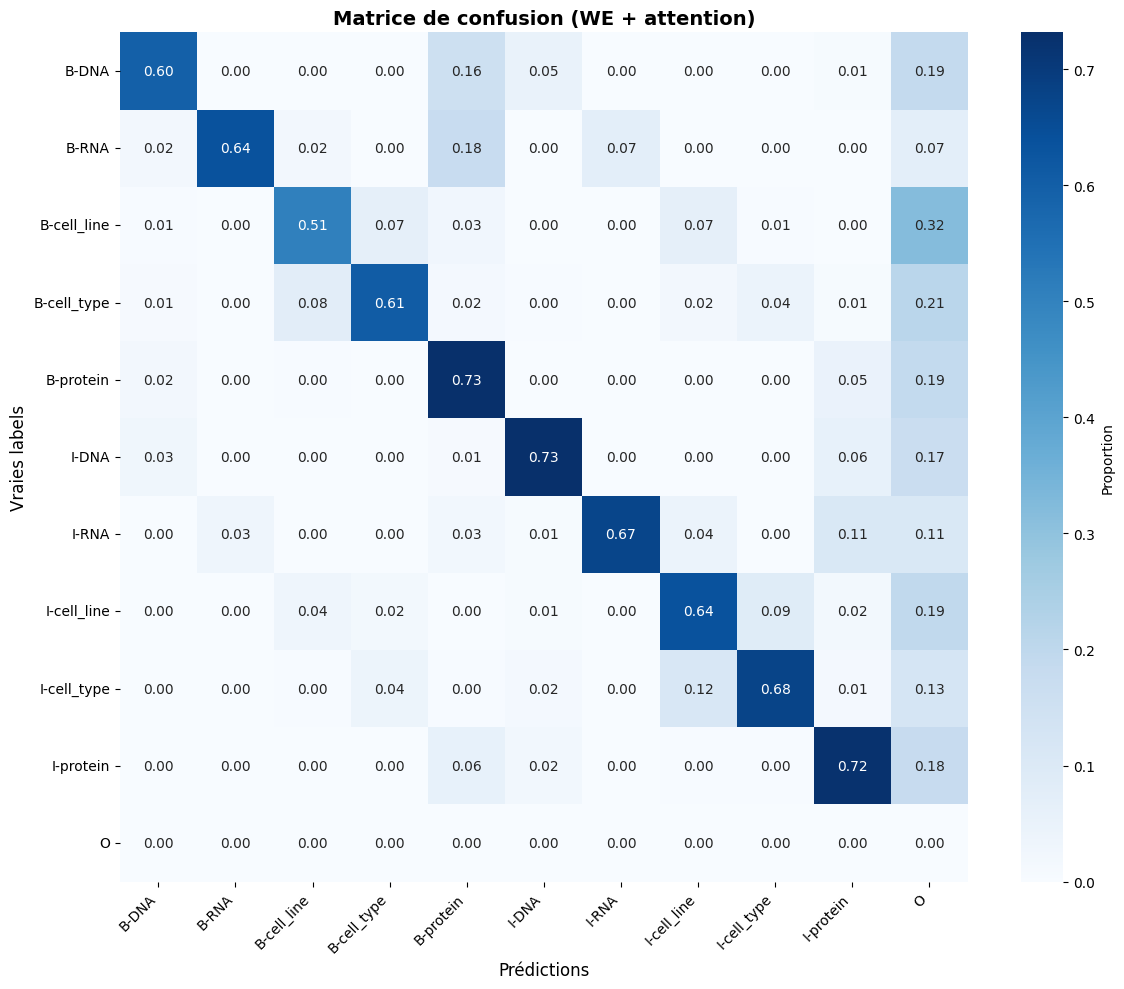

              precision    recall  f1-score   support

       B-DNA       0.75      0.60      0.67       855
       B-RNA       0.85      0.64      0.73        96
 B-cell_line       0.51      0.51      0.51       393
 B-cell_type       0.87      0.61      0.72      1729
   B-protein       0.87      0.73      0.80      4505
       I-DNA       0.83      0.73      0.78      1393
       I-RNA       0.90      0.67      0.77       156
 I-cell_line       0.56      0.64      0.59       792
 I-cell_type       0.92      0.68      0.78      2690
   I-protein       0.88      0.72      0.80      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.69     16829
   macro avg       0.72      0.59      0.65     16829
weighted avg       0.85      0.69      0.76     16829

B-DNA               : Precision=0.753, Recall=0.596, F1=0.666, Support=855
B-RNA               : Precision=0.847, Recall=0.635, F1=0.726, Support=96
B-cell_line         : Precision=0.509,

In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_attention, predictions_we_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_attention, targets_we_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_attention, targets_we_attention) if t != 'O']



if set(predictions_we_attention) == set(targets_we_attention) or all(isinstance(p, str) for p in predictions_we_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_attention,
        targets=targets_we_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_attention[:10])}")

WE + char(bi-lstm)

In [ ]:
model_we_char_bilstm , history_we_char_bilstm = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=8,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,011,722


Training: 100%|██████████| 491/491 [01:06<00:00,  7.33it/s]


Epoch 01/100 | Train loss: 314.5531 | Dev loss: 181.9578 | P: 0.7328 R: 0.6167 F1: 0.6651 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt : (F1: 0.6651)


Training: 100%|██████████| 491/491 [01:07<00:00,  7.25it/s]


Epoch 02/100 | Train loss: 129.5836 | Dev loss: 144.2897 | P: 0.7342 R: 0.6780 F1: 0.7023 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt : (F1: 0.7023)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.61it/s]


Epoch 03/100 | Train loss: 96.2404 | Dev loss: 130.4388 | P: 0.7315 R: 0.7165 F1: 0.7227 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt : (F1: 0.7227)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s]


Epoch 04/100 | Train loss: 77.4333 | Dev loss: 132.8740 | P: 0.7526 R: 0.6600 F1: 0.6986 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.73it/s]


Epoch 05/100 | Train loss: 64.4641 | Dev loss: 126.1566 | P: 0.7318 R: 0.7117 F1: 0.7209 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.71it/s]


Epoch 06/100 | Train loss: 54.2988 | Dev loss: 126.9147 | P: 0.7348 R: 0.7097 F1: 0.7213 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:14<00:00,  6.61it/s]


Epoch 07/100 | Train loss: 41.8473 | Dev loss: 136.4753 | P: 0.7362 R: 0.6962 F1: 0.7143 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:02<00:00,  7.83it/s]


Epoch 08/100 | Train loss: 36.5770 | Dev loss: 140.8840 | P: 0.7360 R: 0.7006 F1: 0.7173 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:37<00:00,  5.01it/s]


Epoch 09/100 | Train loss: 32.2979 | Dev loss: 143.7041 | P: 0.7341 R: 0.7007 F1: 0.7157 | LR: 0.000250


Training: 100%|██████████| 491/491 [02:42<00:00,  3.01it/s]


Epoch 10/100 | Train loss: 25.8879 | Dev loss: 149.8826 | P: 0.7240 R: 0.7012 F1: 0.7114 | LR: 0.000250


Training: 100%|██████████| 491/491 [03:10<00:00,  2.57it/s]


Epoch 11/100 | Train loss: 23.1722 | Dev loss: 157.0657 | P: 0.7307 R: 0.6926 F1: 0.7102 | LR: 0.000250

Early stopping triggered après 11 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 142.7872
Precision: 0.6462
Recall: 0.6853
F1-score: 0.6612

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 6: LR = 0.000500
  Epoch 9: LR = 0.000250


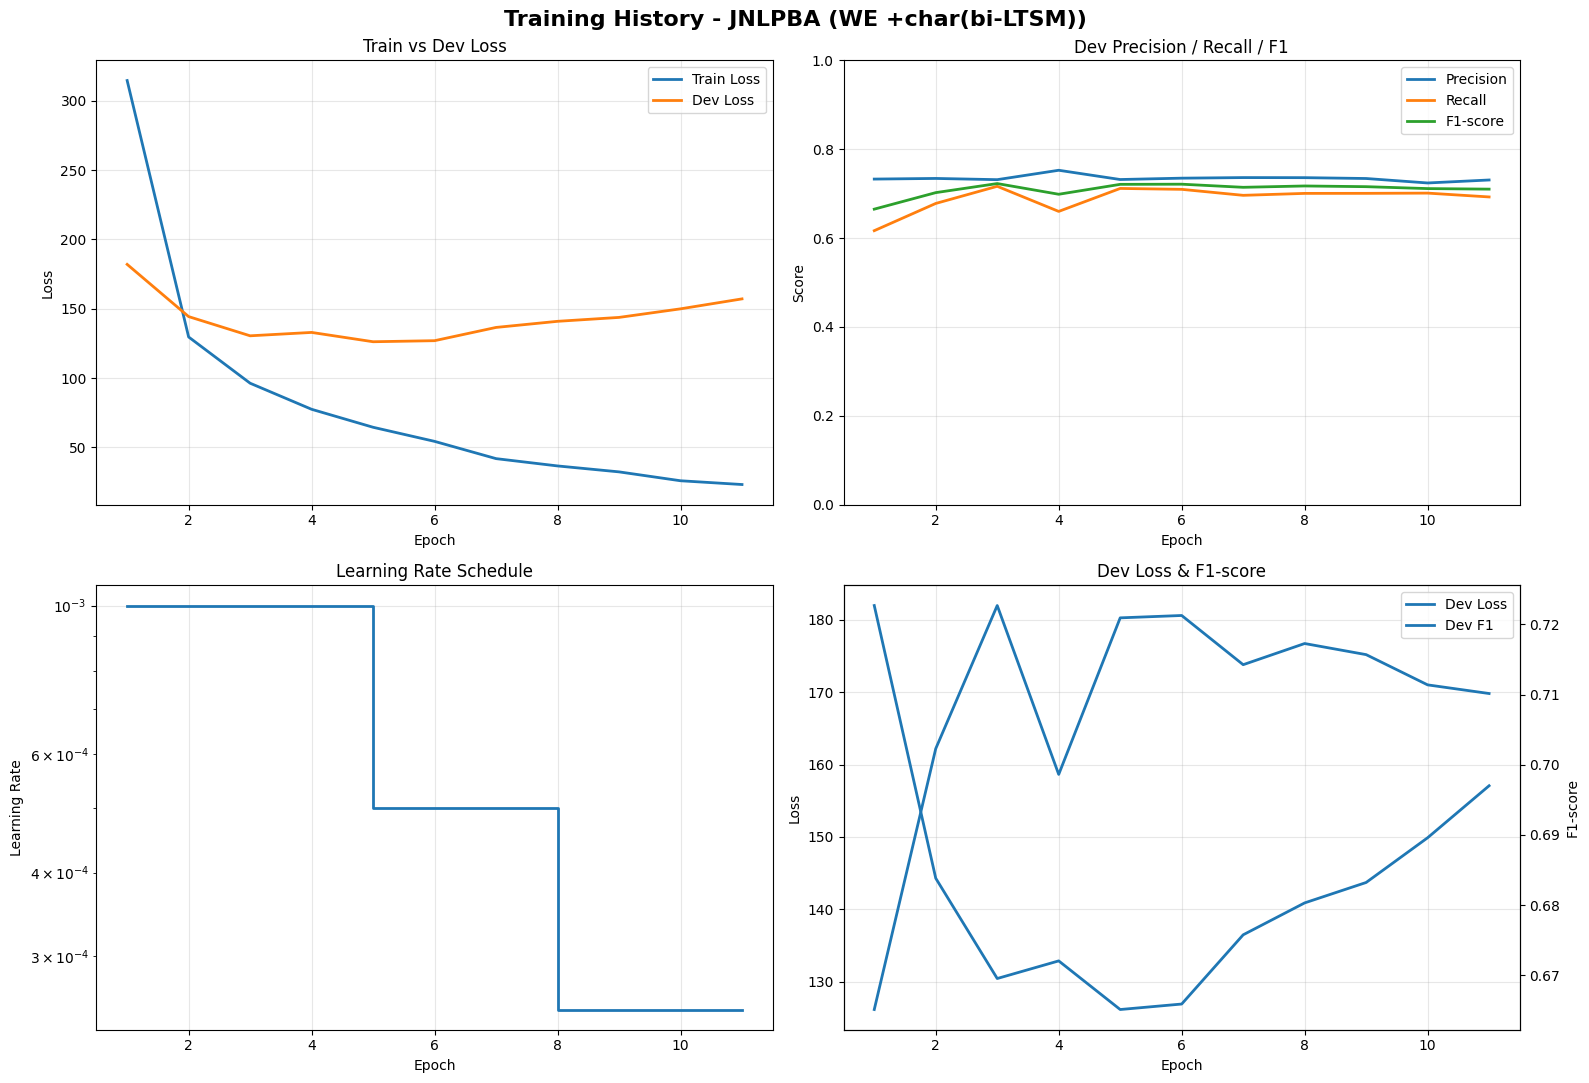


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM))
Meilleur F1 (dev)       : 0.7227
Meilleure Precision(dev): 0.7526
Meilleur Recall (dev)   : 0.7165
Final train loss        : 23.1722
Final dev loss          : 157.0657
Final learning rate     : 0.000250


In [25]:
plot_training_history(history_we_char_bilstm, dataset_name="JNLPBA (WE +char(bi-LTSM))")

In [27]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt"
model_we_char_bilstm , device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)

test_loader = results_jnlpba['test_loader']
predictions_we_char, targets_we_char = predict_on_test_set(
    model=model_we_char_bilstm ,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt
Best F1 enregistré: 0.7227
Époque: 2
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O               


Accuracy globale: 0.9279

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


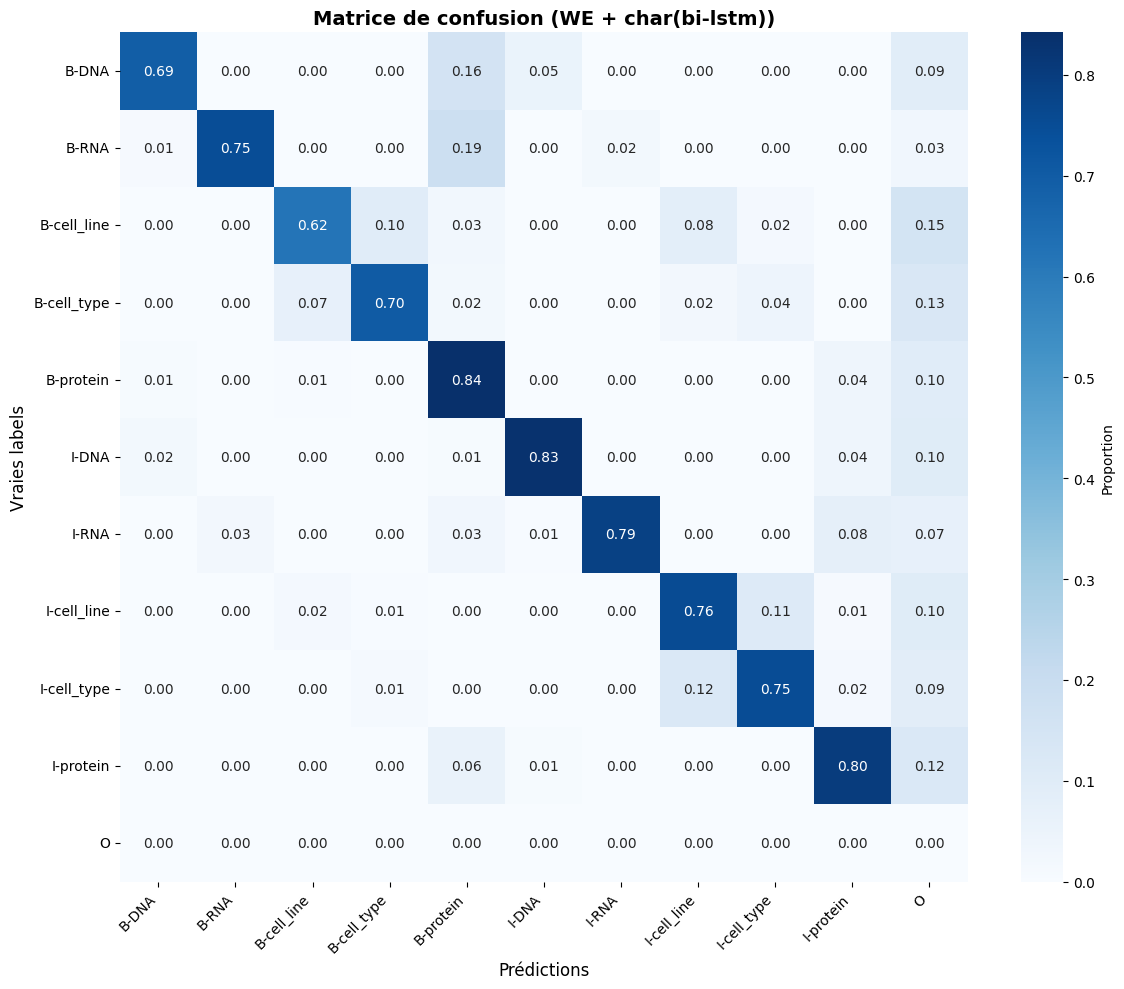

              precision    recall  f1-score   support

       B-DNA       0.89      0.69      0.78       855
       B-RNA       0.84      0.75      0.79        96
 B-cell_line       0.59      0.62      0.61       393
 B-cell_type       0.93      0.70      0.80      1729
   B-protein       0.89      0.84      0.86      4505
       I-DNA       0.93      0.83      0.88      1393
       I-RNA       0.92      0.79      0.85       156
 I-cell_line       0.59      0.76      0.66       792
 I-cell_type       0.92      0.75      0.83      2690
   I-protein       0.92      0.80      0.86      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.78     16829
   macro avg       0.76      0.69      0.72     16829
weighted avg       0.89      0.78      0.83     16829

B-DNA               : Precision=0.889, Recall=0.692, F1=0.778, Support=855
B-RNA               : Precision=0.837, Recall=0.750, F1=0.791, Support=96
B-cell_line         : Precision=0.591,

In [35]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char, predictions_we_char)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char, targets_we_char) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char, targets_we_char) if t != 'O']

if set(predictions_we_char) == set(targets_we_char) or all(isinstance(p, str) for p in predictions_we_char):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char,
        targets=targets_we_char,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char[:10])}")

WE + char(bi-lstm) + attention

In [ ]:
model_we_char_attention, history_we_char_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=8,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,077,770


Training: 100%|██████████| 491/491 [01:07<00:00,  7.26it/s]


Epoch 01/100 | Train loss: 741.7516 | Dev loss: 493.8808 | P: 0.0217 R: 0.0496 F1: 0.0302 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.0302)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.19it/s]


Epoch 02/100 | Train loss: 407.8724 | Dev loss: 390.2777 | P: 0.0703 R: 0.1292 F1: 0.0910 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.0910)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.15it/s]


Epoch 03/100 | Train loss: 325.6743 | Dev loss: 329.2101 | P: 0.0701 R: 0.1454 F1: 0.0944 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.0944)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.14it/s]


Epoch 04/100 | Train loss: 275.8786 | Dev loss: 300.6445 | P: 0.0702 R: 0.1443 F1: 0.0941 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:07<00:00,  7.29it/s]


Epoch 05/100 | Train loss: 242.8097 | Dev loss: 281.9736 | P: 0.0651 R: 0.1572 F1: 0.0915 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:05<00:00,  7.55it/s]


Epoch 06/100 | Train loss: 220.6278 | Dev loss: 269.6644 | P: 0.0906 R: 0.1441 F1: 0.0975 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.0975)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.71it/s]


Epoch 07/100 | Train loss: 204.1171 | Dev loss: 261.1676 | P: 0.1199 R: 0.1527 F1: 0.1208 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.1208)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s]


Epoch 08/100 | Train loss: 192.2805 | Dev loss: 248.5211 | P: 0.0926 R: 0.1533 F1: 0.1018 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.79it/s]


Epoch 09/100 | Train loss: 181.3998 | Dev loss: 248.6776 | P: 0.1832 R: 0.1573 F1: 0.1218 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.1218)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s]


Epoch 10/100 | Train loss: 173.0568 | Dev loss: 241.6876 | P: 0.2064 R: 0.1751 F1: 0.1443 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.1443)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.76it/s]


Epoch 11/100 | Train loss: 163.8893 | Dev loss: 236.4448 | P: 0.2012 R: 0.1793 F1: 0.1434 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.76it/s]


Epoch 12/100 | Train loss: 155.6957 | Dev loss: 247.9456 | P: 0.2670 R: 0.2300 F1: 0.2198 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.2198)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.61it/s]


Epoch 13/100 | Train loss: 148.8994 | Dev loss: 243.8668 | P: 0.2806 R: 0.2489 F1: 0.2399 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.2399)


Training: 100%|██████████| 491/491 [01:16<00:00,  6.40it/s]


Epoch 14/100 | Train loss: 141.3982 | Dev loss: 262.0404 | P: 0.2940 R: 0.2662 F1: 0.2600 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.2600)


Training: 100%|██████████| 491/491 [01:15<00:00,  6.50it/s]


Epoch 15/100 | Train loss: 135.0140 | Dev loss: 265.0197 | P: 0.2939 R: 0.2765 F1: 0.2586 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:09<00:00,  7.10it/s]


Epoch 16/100 | Train loss: 128.3818 | Dev loss: 251.0892 | P: 0.2979 R: 0.2947 F1: 0.2815 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.2815)


Training: 100%|██████████| 491/491 [02:52<00:00,  2.84it/s]


Epoch 17/100 | Train loss: 123.2891 | Dev loss: 257.4354 | P: 0.3265 R: 0.3082 F1: 0.2949 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.2949)


Training: 100%|██████████| 491/491 [03:41<00:00,  2.21it/s]


Epoch 18/100 | Train loss: 117.4181 | Dev loss: 266.7170 | P: 0.3081 R: 0.3136 F1: 0.2950 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.2950)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.62it/s]


Epoch 19/100 | Train loss: 113.4049 | Dev loss: 279.8078 | P: 0.3156 R: 0.3198 F1: 0.3047 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3047)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.68it/s]


Epoch 20/100 | Train loss: 108.4817 | Dev loss: 274.8668 | P: 0.3081 R: 0.3175 F1: 0.2991 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.70it/s]


Epoch 21/100 | Train loss: 103.8358 | Dev loss: 293.5234 | P: 0.3282 R: 0.3319 F1: 0.3109 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3109)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.73it/s]


Epoch 22/100 | Train loss: 99.7286 | Dev loss: 308.6930 | P: 0.3341 R: 0.3266 F1: 0.3160 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3160)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s]


Epoch 23/100 | Train loss: 95.4144 | Dev loss: 303.7885 | P: 0.3524 R: 0.3534 F1: 0.3377 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3377)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.71it/s]


Epoch 24/100 | Train loss: 92.2036 | Dev loss: 297.2109 | P: 0.3538 R: 0.3573 F1: 0.3376 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.72it/s]


Epoch 25/100 | Train loss: 88.7381 | Dev loss: 379.7728 | P: 0.3661 R: 0.3175 F1: 0.3261 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.76it/s]


Epoch 26/100 | Train loss: 85.1939 | Dev loss: 355.1092 | P: 0.3715 R: 0.3479 F1: 0.3407 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3407)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.82it/s]


Epoch 27/100 | Train loss: 81.1007 | Dev loss: 319.4022 | P: 0.3505 R: 0.3827 F1: 0.3535 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3535)


Training: 100%|██████████| 491/491 [01:05<00:00,  7.52it/s]


Epoch 28/100 | Train loss: 77.7232 | Dev loss: 320.9389 | P: 0.3767 R: 0.3887 F1: 0.3691 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3691)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.62it/s]


Epoch 29/100 | Train loss: 74.1271 | Dev loss: 347.5405 | P: 0.3988 R: 0.4008 F1: 0.3858 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.3858)


Training: 100%|██████████| 491/491 [01:05<00:00,  7.55it/s]


Epoch 30/100 | Train loss: 71.3829 | Dev loss: 350.8139 | P: 0.4004 R: 0.3926 F1: 0.3836 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:04<00:00,  7.67it/s]


Epoch 31/100 | Train loss: 68.8995 | Dev loss: 311.7358 | P: 0.4035 R: 0.4357 F1: 0.4136 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.4136)


Training: 100%|██████████| 491/491 [01:07<00:00,  7.32it/s]


Epoch 32/100 | Train loss: 65.0211 | Dev loss: 335.5832 | P: 0.4228 R: 0.4330 F1: 0.4236 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.4236)


Training: 100%|██████████| 491/491 [01:07<00:00,  7.31it/s]


Epoch 33/100 | Train loss: 61.1085 | Dev loss: 325.5763 | P: 0.4214 R: 0.4470 F1: 0.4317 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.4317)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.56it/s]


Epoch 34/100 | Train loss: 56.0293 | Dev loss: 353.7420 | P: 0.5700 R: 0.4576 F1: 0.4462 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.4462)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.41it/s]


Epoch 35/100 | Train loss: 52.3777 | Dev loss: 341.2247 | P: 0.4911 R: 0.4665 F1: 0.4614 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.4614)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.38it/s]


Epoch 36/100 | Train loss: 47.8437 | Dev loss: 304.8380 | P: 0.4780 R: 0.4934 F1: 0.4706 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.4706)


Training: 100%|██████████| 491/491 [01:18<00:00,  6.27it/s]


Epoch 37/100 | Train loss: 44.5017 | Dev loss: 341.7475 | P: 0.5481 R: 0.4903 F1: 0.4873 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.4873)


Training: 100%|██████████| 491/491 [01:17<00:00,  6.30it/s]


Epoch 38/100 | Train loss: 41.6053 | Dev loss: 330.3574 | P: 0.5976 R: 0.5186 F1: 0.5353 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.5353)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.21it/s]


Epoch 39/100 | Train loss: 38.9846 | Dev loss: 346.6990 | P: 0.6238 R: 0.5206 F1: 0.5577 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.5577)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.58it/s]


Epoch 40/100 | Train loss: 36.4642 | Dev loss: 352.2588 | P: 0.6121 R: 0.5529 F1: 0.5693 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.5693)


Training: 100%|██████████| 491/491 [01:05<00:00,  7.49it/s]


Epoch 41/100 | Train loss: 34.2693 | Dev loss: 298.7140 | P: 0.6531 R: 0.5560 F1: 0.5845 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.5845)


Training: 100%|██████████| 491/491 [01:18<00:00,  6.24it/s]


Epoch 42/100 | Train loss: 32.2009 | Dev loss: 297.1070 | P: 0.6414 R: 0.5874 F1: 0.6020 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6020)


Training: 100%|██████████| 491/491 [01:17<00:00,  6.33it/s]


Epoch 43/100 | Train loss: 29.3628 | Dev loss: 327.4484 | P: 0.6547 R: 0.5837 F1: 0.6057 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6057)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.12it/s]


Epoch 44/100 | Train loss: 27.3522 | Dev loss: 343.6330 | P: 0.6457 R: 0.5721 F1: 0.6000 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:06<00:00,  7.42it/s]


Epoch 45/100 | Train loss: 26.5812 | Dev loss: 336.2100 | P: 0.6516 R: 0.5880 F1: 0.6125 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6125)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.61it/s]


Epoch 46/100 | Train loss: 25.5962 | Dev loss: 327.1191 | P: 0.6505 R: 0.6007 F1: 0.6168 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6168)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.41it/s]


Epoch 47/100 | Train loss: 23.9370 | Dev loss: 324.6603 | P: 0.6685 R: 0.5770 F1: 0.6127 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:13<00:00,  6.66it/s]


Epoch 48/100 | Train loss: 22.1840 | Dev loss: 360.3009 | P: 0.6633 R: 0.5854 F1: 0.6150 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:17<00:00,  6.30it/s]


Epoch 49/100 | Train loss: 21.7463 | Dev loss: 338.0667 | P: 0.6674 R: 0.5855 F1: 0.6173 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6173)


Training: 100%|██████████| 491/491 [01:16<00:00,  6.45it/s]


Epoch 50/100 | Train loss: 21.7724 | Dev loss: 329.7524 | P: 0.6636 R: 0.6113 F1: 0.6331 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6331)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.72it/s]


Epoch 51/100 | Train loss: 20.6097 | Dev loss: 333.7153 | P: 0.6677 R: 0.6064 F1: 0.6317 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:02<00:00,  7.80it/s]


Epoch 52/100 | Train loss: 18.6475 | Dev loss: 331.6646 | P: 0.6655 R: 0.5982 F1: 0.6247 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.75it/s]


Epoch 53/100 | Train loss: 18.3891 | Dev loss: 298.0969 | P: 0.6516 R: 0.6303 F1: 0.6371 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6371)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.20it/s]


Epoch 54/100 | Train loss: 17.7554 | Dev loss: 325.0631 | P: 0.6690 R: 0.6092 F1: 0.6332 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:05<00:00,  7.48it/s]


Epoch 55/100 | Train loss: 17.1158 | Dev loss: 316.2640 | P: 0.6751 R: 0.6011 F1: 0.6319 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.79it/s]


Epoch 56/100 | Train loss: 16.6723 | Dev loss: 327.9621 | P: 0.6692 R: 0.6132 F1: 0.6378 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6378)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s]


Epoch 57/100 | Train loss: 14.7430 | Dev loss: 354.3415 | P: 0.6849 R: 0.5915 F1: 0.6299 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.76it/s]


Epoch 58/100 | Train loss: 14.7743 | Dev loss: 386.9269 | P: 0.6786 R: 0.6065 F1: 0.6377 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:02<00:00,  7.80it/s]


Epoch 59/100 | Train loss: 15.5278 | Dev loss: 318.0734 | P: 0.6839 R: 0.6144 F1: 0.6442 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6442)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.33it/s]


Epoch 60/100 | Train loss: 15.3861 | Dev loss: 307.5482 | P: 0.6547 R: 0.6432 F1: 0.6464 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6464)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.66it/s]


Epoch 61/100 | Train loss: 13.2676 | Dev loss: 327.1300 | P: 0.6830 R: 0.6239 F1: 0.6493 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6493)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.44it/s]


Epoch 62/100 | Train loss: 12.8210 | Dev loss: 301.5964 | P: 0.6827 R: 0.6319 F1: 0.6525 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6525)


Training: 100%|██████████| 491/491 [01:07<00:00,  7.26it/s]


Epoch 63/100 | Train loss: 12.7455 | Dev loss: 322.2533 | P: 0.6821 R: 0.6152 F1: 0.6443 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:02<00:00,  7.81it/s]


Epoch 64/100 | Train loss: 11.9285 | Dev loss: 365.8936 | P: 0.6854 R: 0.6042 F1: 0.6401 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:04<00:00,  7.64it/s]


Epoch 65/100 | Train loss: 11.2650 | Dev loss: 398.2506 | P: 0.6766 R: 0.5977 F1: 0.6322 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:07<00:00,  7.26it/s]


Epoch 66/100 | Train loss: 9.4082 | Dev loss: 320.5301 | P: 0.6723 R: 0.6369 F1: 0.6524 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:06<00:00,  7.43it/s]


Epoch 67/100 | Train loss: 7.3707 | Dev loss: 338.7281 | P: 0.6780 R: 0.6325 F1: 0.6523 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:04<00:00,  7.60it/s]


Epoch 68/100 | Train loss: 6.8656 | Dev loss: 363.3011 | P: 0.6743 R: 0.6299 F1: 0.6487 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:02<00:00,  7.81it/s]


Epoch 69/100 | Train loss: 6.2963 | Dev loss: 366.0291 | P: 0.6747 R: 0.6330 F1: 0.6510 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:03<00:00,  7.71it/s]


Epoch 70/100 | Train loss: 6.0249 | Dev loss: 366.5522 | P: 0.6759 R: 0.6361 F1: 0.6537 | LR: 0.000250
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.6537)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.79it/s]


Epoch 71/100 | Train loss: 5.8151 | Dev loss: 369.1031 | P: 0.6729 R: 0.6343 F1: 0.6512 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:05<00:00,  7.52it/s]


Epoch 72/100 | Train loss: 5.6125 | Dev loss: 375.7487 | P: 0.6763 R: 0.6288 F1: 0.6492 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s]


Epoch 73/100 | Train loss: 5.4636 | Dev loss: 391.2172 | P: 0.6764 R: 0.6275 F1: 0.6483 | LR: 0.000125


Training: 100%|██████████| 491/491 [01:04<00:00,  7.66it/s]


Epoch 74/100 | Train loss: 5.1407 | Dev loss: 380.8952 | P: 0.6712 R: 0.6288 F1: 0.6473 | LR: 0.000125


Training: 100%|██████████| 491/491 [01:05<00:00,  7.51it/s]


Epoch 75/100 | Train loss: 4.9339 | Dev loss: 389.9018 | P: 0.6738 R: 0.6282 F1: 0.6477 | LR: 0.000125


Training: 100%|██████████| 491/491 [01:08<00:00,  7.22it/s]


Epoch 76/100 | Train loss: 4.8298 | Dev loss: 388.5027 | P: 0.6758 R: 0.6259 F1: 0.6474 | LR: 0.000063


Training: 100%|██████████| 491/491 [01:19<00:00,  6.15it/s]


Epoch 77/100 | Train loss: 4.6582 | Dev loss: 390.7780 | P: 0.6780 R: 0.6304 F1: 0.6505 | LR: 0.000063


Training: 100%|██████████| 491/491 [01:20<00:00,  6.12it/s]


Epoch 78/100 | Train loss: 4.5890 | Dev loss: 393.2733 | P: 0.6734 R: 0.6260 F1: 0.6462 | LR: 0.000063

Early stopping triggered après 78 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 387.6634
Precision: 0.5770
Recall: 0.6022
F1-score: 0.5855

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 65: LR = 0.000500
  Epoch 68: LR = 0.000250
  Epoch 73: LR = 0.000125
  Epoch 76: LR = 0.000063


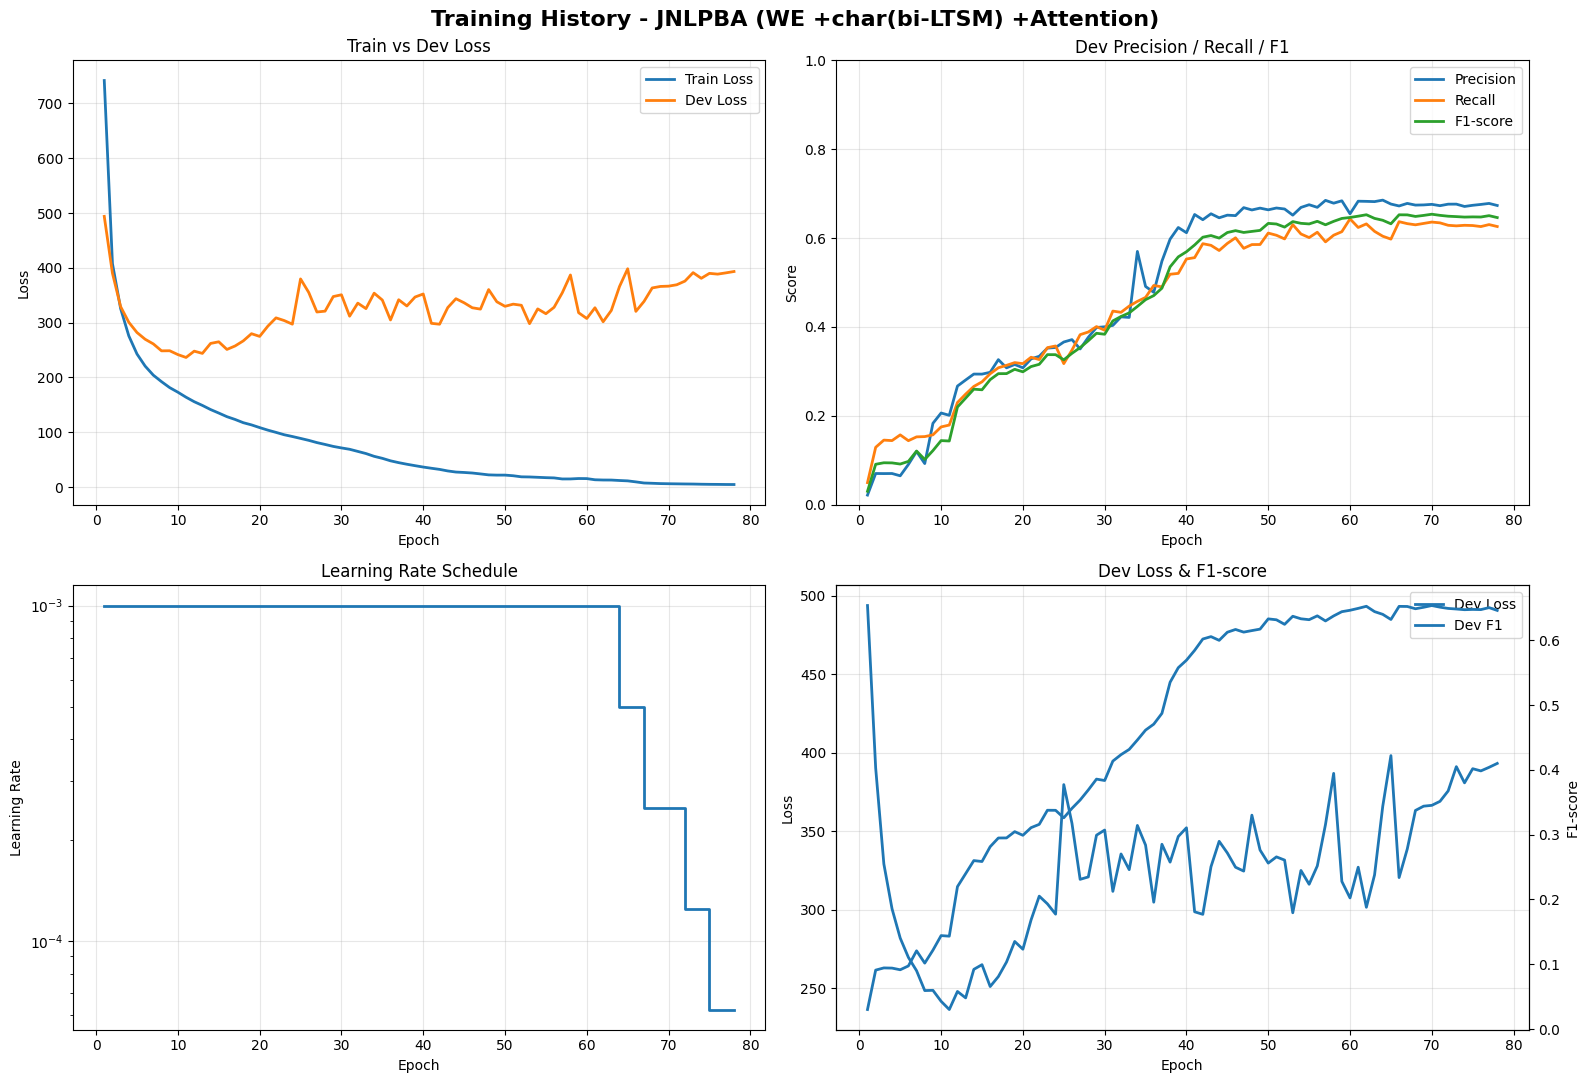


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM) +Attention)
Meilleur F1 (dev)       : 0.6537
Meilleure Precision(dev): 0.6854
Meilleur Recall (dev)   : 0.6432
Final train loss        : 4.5890
Final dev loss          : 393.2733
Final learning rate     : 0.000063


In [19]:
plot_training_history(history_we_char_attention, dataset_name="JNLPBA (WE +char(bi-LTSM) +Attention)")

In [21]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt"
model_we_char_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions_we_char_attention, targets_we_char_attention = predict_on_test_set(
    model=model_we_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt
Best F1 enregistré: 0.6537
Époque: 69
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_line        correct
  9 | I-cell_line        | I-cell_line        correct
 10 | I-cell_line        | I-cell_line        correct
 11 | I-cell_line        | I-cell_line        correct
 12 | O                  | O            


Accuracy globale: 0.9005

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


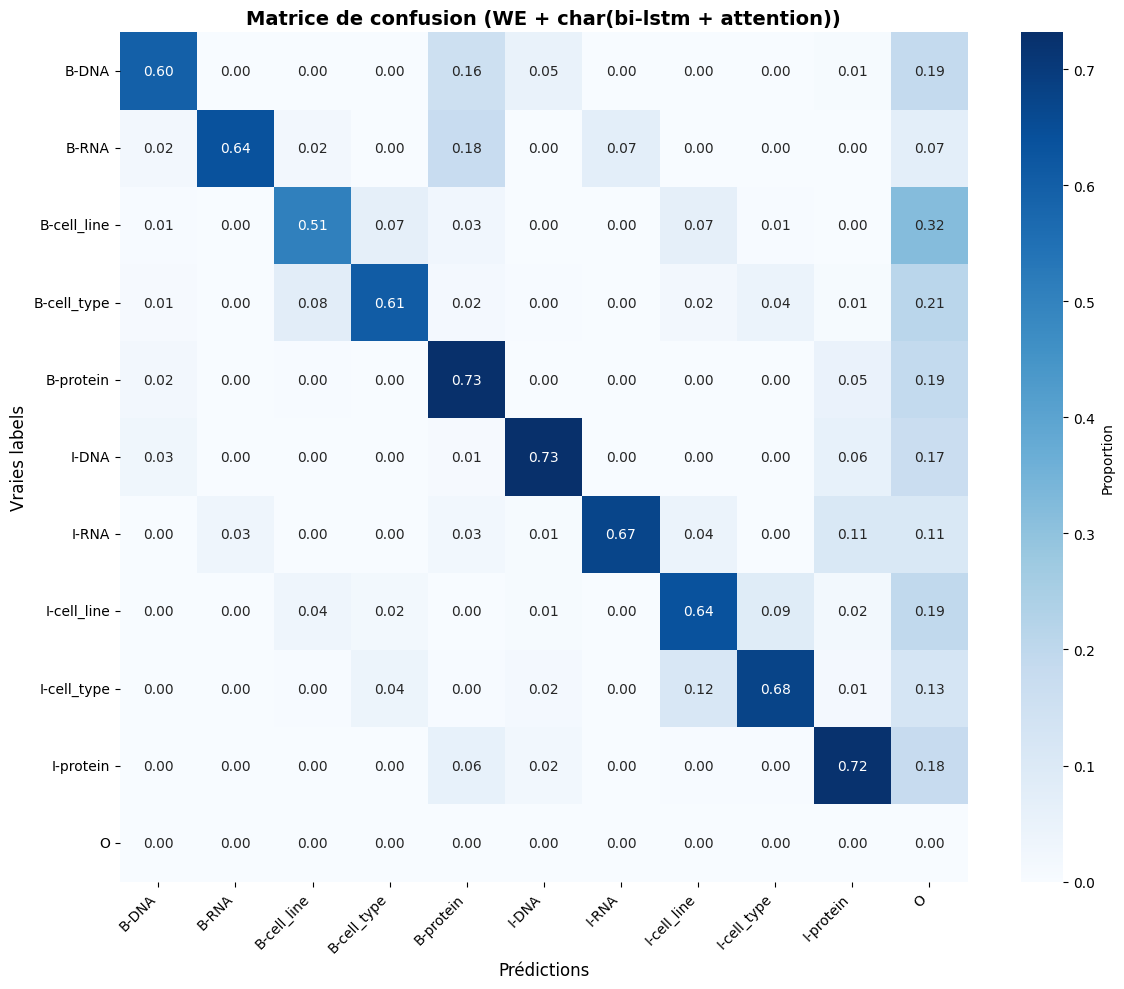

              precision    recall  f1-score   support

       B-DNA       0.75      0.60      0.67       855
       B-RNA       0.85      0.64      0.73        96
 B-cell_line       0.51      0.51      0.51       393
 B-cell_type       0.87      0.61      0.72      1729
   B-protein       0.87      0.73      0.80      4505
       I-DNA       0.83      0.73      0.78      1393
       I-RNA       0.90      0.67      0.77       156
 I-cell_line       0.56      0.64      0.59       792
 I-cell_type       0.92      0.68      0.78      2690
   I-protein       0.88      0.72      0.80      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.69     16829
   macro avg       0.72      0.59      0.65     16829
weighted avg       0.85      0.69      0.76     16829

B-DNA               : Precision=0.753, Recall=0.596, F1=0.666, Support=855
B-RNA               : Precision=0.847, Recall=0.635, F1=0.726, Support=96
B-cell_line         : Precision=0.509,

In [36]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_attention, predictions_we_char_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_attention, targets_we_char_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_attention, targets_we_char_attention) if t != 'O']

if set(predictions_we_char_attention) == set(targets_we_char_attention) or all(isinstance(p, str) for p in predictions_we_char_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_attention,
        targets=targets_we_char_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm + attention))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_attention[:10])}")

WE + char(cnn)

In [ ]:
model_we_char_cnn, history_we_char_cnn = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=8,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 2,989,322


Training: 100%|██████████| 491/491 [01:03<00:00,  7.72it/s]


Epoch 01/100 | Train loss: 304.8432 | Dev loss: 170.6220 | P: 0.7098 R: 0.6914 F1: 0.6961 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn/best_model.pt : (F1: 0.6961)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.95it/s]


Epoch 02/100 | Train loss: 126.2227 | Dev loss: 145.9058 | P: 0.7608 R: 0.6608 F1: 0.7060 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn/best_model.pt : (F1: 0.7060)


Training: 100%|██████████| 491/491 [02:28<00:00,  3.31it/s]


Epoch 03/100 | Train loss: 96.1850 | Dev loss: 128.5621 | P: 0.7408 R: 0.7006 F1: 0.7164 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn/best_model.pt : (F1: 0.7164)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.62it/s]


Epoch 04/100 | Train loss: 77.9436 | Dev loss: 125.6368 | P: 0.7535 R: 0.6756 F1: 0.7091 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:03<00:00,  7.68it/s]


Epoch 05/100 | Train loss: 64.9611 | Dev loss: 121.9336 | P: 0.7550 R: 0.6996 F1: 0.7251 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn/best_model.pt : (F1: 0.7251)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.66it/s]


Epoch 06/100 | Train loss: 55.5841 | Dev loss: 122.7275 | P: 0.7461 R: 0.7013 F1: 0.7216 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:04<00:00,  7.61it/s]


Epoch 07/100 | Train loss: 48.5395 | Dev loss: 125.0375 | P: 0.7366 R: 0.7067 F1: 0.7192 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:05<00:00,  7.48it/s]


Epoch 08/100 | Train loss: 41.4666 | Dev loss: 135.2443 | P: 0.7352 R: 0.7074 F1: 0.7199 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:11<00:00,  6.83it/s]


Epoch 09/100 | Train loss: 31.0344 | Dev loss: 133.7153 | P: 0.7456 R: 0.6996 F1: 0.7212 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:04<00:00,  7.67it/s]


Epoch 10/100 | Train loss: 26.7276 | Dev loss: 140.4850 | P: 0.7292 R: 0.7095 F1: 0.7177 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:03<00:00,  7.75it/s]


Epoch 11/100 | Train loss: 23.2968 | Dev loss: 149.0316 | P: 0.7230 R: 0.7034 F1: 0.7118 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:00<00:00,  8.15it/s]


Epoch 12/100 | Train loss: 18.4588 | Dev loss: 158.5588 | P: 0.7404 R: 0.6813 F1: 0.7079 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:52<00:00,  4.38it/s]


Epoch 13/100 | Train loss: 16.1005 | Dev loss: 166.4876 | P: 0.7375 R: 0.6823 F1: 0.7073 | LR: 0.000250

Early stopping triggered après 13 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 138.4133
Precision: 0.6682
Recall: 0.6698
F1-score: 0.6656

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 8: LR = 0.000500
  Epoch 11: LR = 0.000250


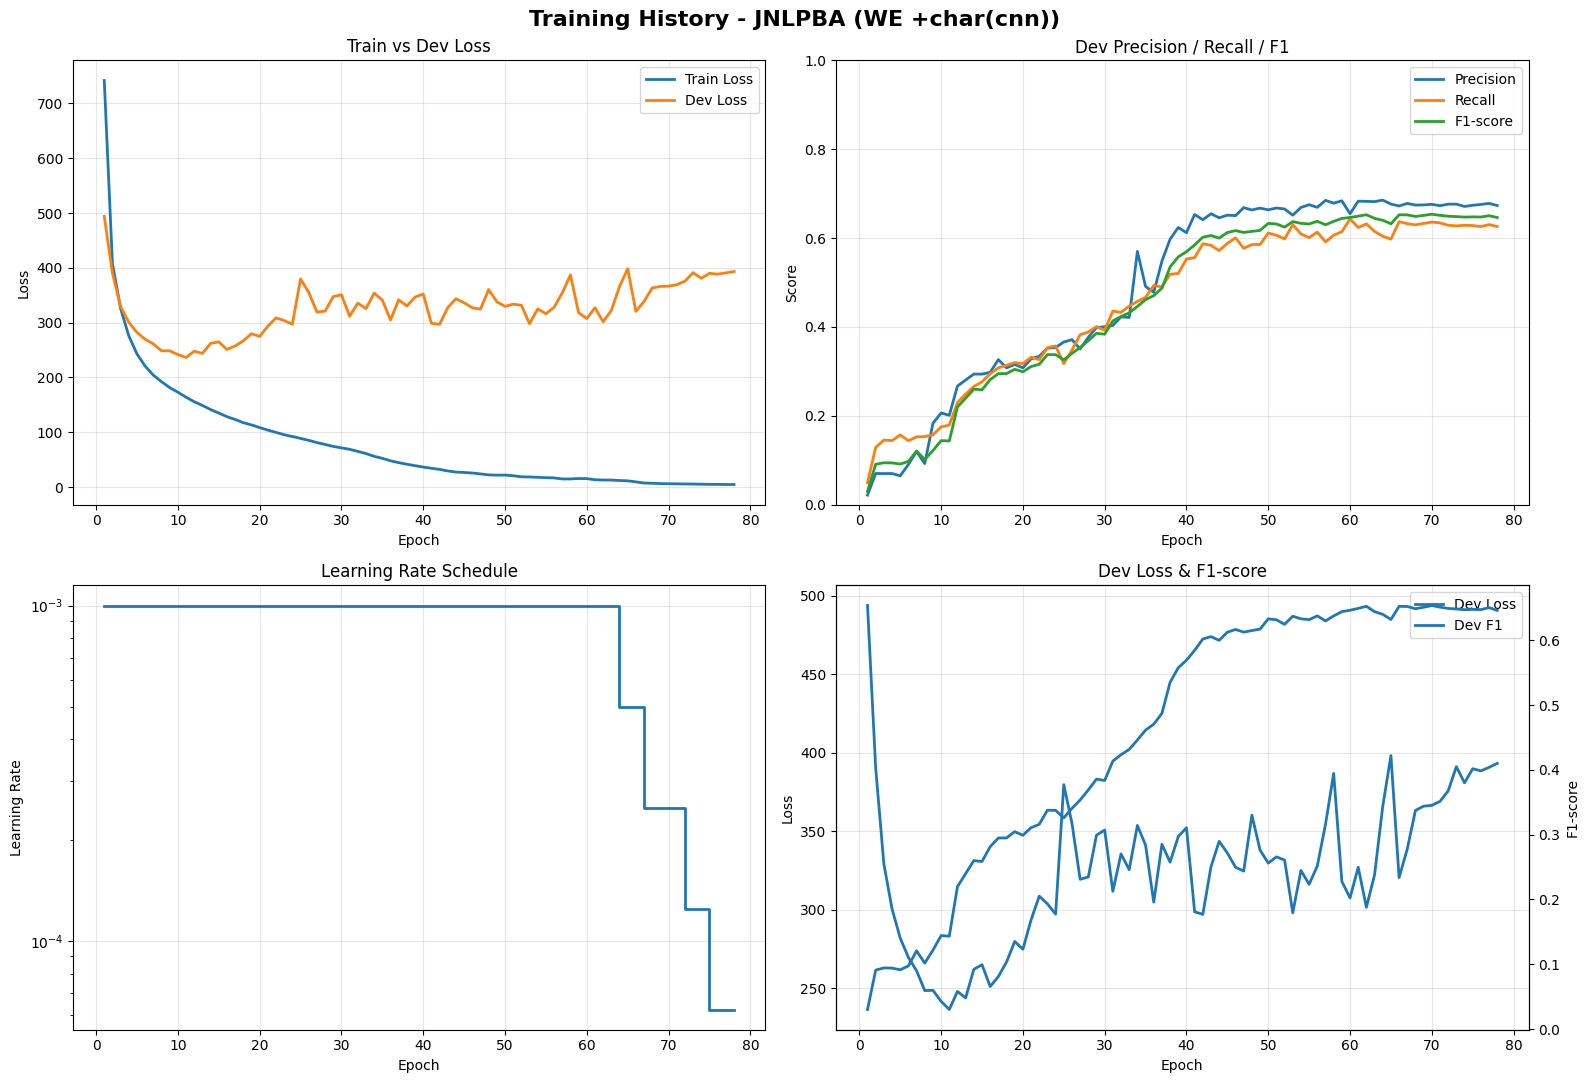


STATISTIQUES FINALES - JNLPBA (WE +char(cnn))
Meilleur F1 (dev)       : 0.6537
Meilleure Precision(dev): 0.6854
Meilleur Recall (dev)   : 0.6432
Final train loss        : 4.5890
Final dev loss          : 393.2733
Final learning rate     : 0.000063


In [38]:
plot_training_history(history_we_char_attention, dataset_name="JNLPBA (WE +char(cnn))")

In [39]:
model_path = "./checkpoints/JNLPBA/WE_char_cnn/best_model.pt"
model_we_char_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char_cnn, targets_we_char_cnn = predict_on_test_set(
    model=model_we_char_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_cnn/best_model.pt
Best F1 enregistré: 0.7251
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-protein          incorrect
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                  co


Accuracy globale: 0.9286

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


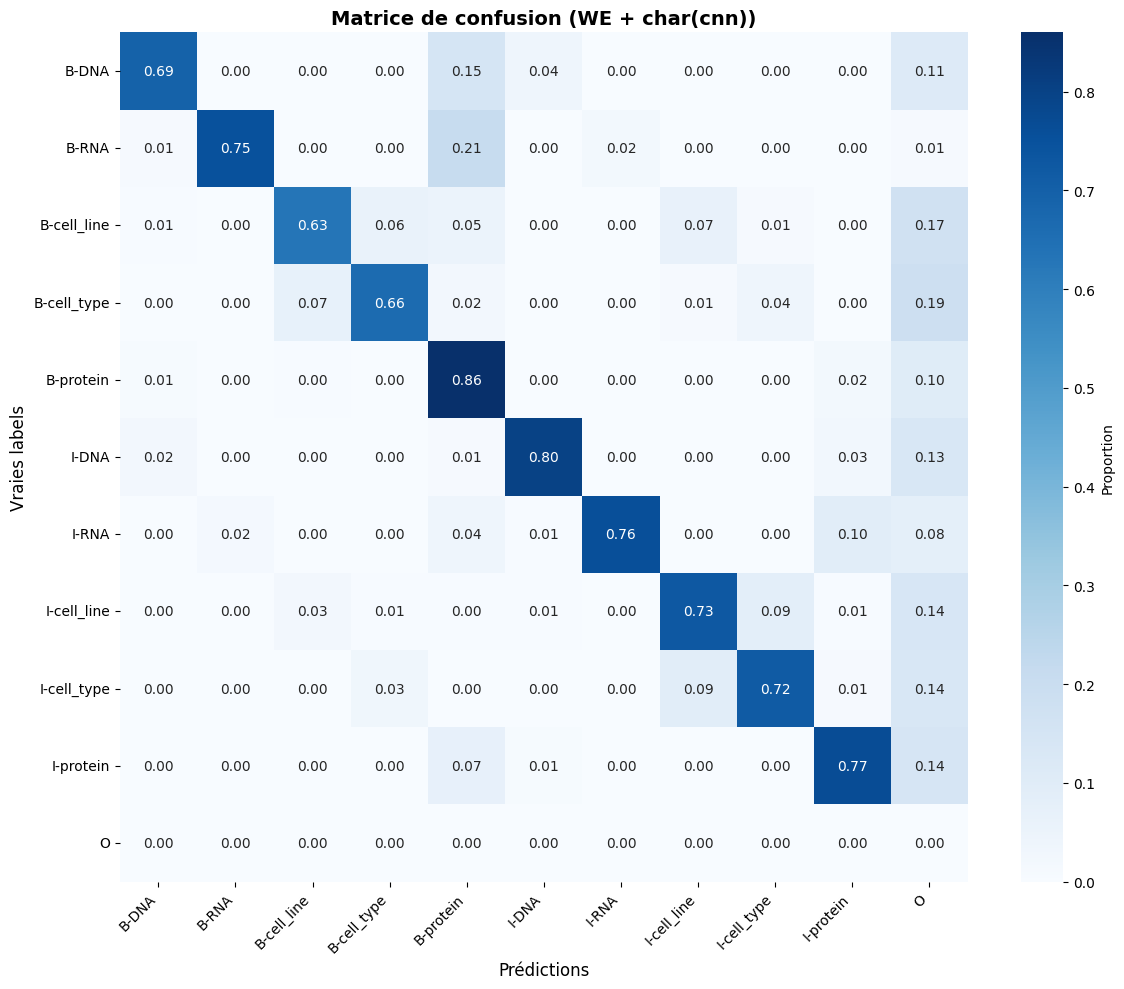

              precision    recall  f1-score   support

       B-DNA       0.89      0.69      0.78       855
       B-RNA       0.85      0.75      0.80        96
 B-cell_line       0.60      0.63      0.62       393
 B-cell_type       0.90      0.66      0.76      1729
   B-protein       0.88      0.86      0.87      4505
       I-DNA       0.93      0.80      0.86      1393
       I-RNA       0.91      0.76      0.83       156
 I-cell_line       0.65      0.73      0.69       792
 I-cell_type       0.93      0.72      0.81      2690
   I-protein       0.94      0.77      0.85      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.77     16829
   macro avg       0.77      0.67      0.71     16829
weighted avg       0.89      0.77      0.82     16829

B-DNA               : Precision=0.893, Recall=0.694, F1=0.781, Support=855
B-RNA               : Precision=0.847, Recall=0.750, F1=0.796, Support=96
B-cell_line         : Precision=0.604,

In [40]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn, predictions_we_char_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_cnn, targets_we_char_cnn) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_cnn, targets_we_char_cnn) if t != 'O']

if set(predictions_we_char_cnn) == set(targets_we_char_cnn) or all(isinstance(p, str) for p in predictions_we_char_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn,
        targets=targets_we_char_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn[:10])}")

WE + char(cnn) + attention

In [ ]:
model_we_char_cnn_attention, history_we_char_cnn_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=4,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,055,370


Training: 100%|██████████| 491/491 [01:15<00:00,  6.50it/s]


Epoch 01/100 | Train loss: 762.6418 | Dev loss: 497.9808 | P: 0.0653 R: 0.0851 F1: 0.0717 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.0717)


Training: 100%|██████████| 491/491 [01:10<00:00,  6.96it/s]


Epoch 02/100 | Train loss: 412.1929 | Dev loss: 391.1293 | P: 0.0675 R: 0.1487 F1: 0.0927 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.0927)


Training: 100%|██████████| 491/491 [01:53<00:00,  4.31it/s]


Epoch 03/100 | Train loss: 328.7944 | Dev loss: 334.8620 | P: 0.0670 R: 0.1541 F1: 0.0931 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.0931)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.98it/s]


Epoch 04/100 | Train loss: 277.7124 | Dev loss: 306.5966 | P: 0.0728 R: 0.1313 F1: 0.0935 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.0935)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.95it/s]


Epoch 05/100 | Train loss: 244.8166 | Dev loss: 278.5382 | P: 0.0693 R: 0.1520 F1: 0.0944 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.0944)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.96it/s]


Epoch 06/100 | Train loss: 222.1475 | Dev loss: 266.0079 | P: 0.0892 R: 0.1564 F1: 0.0981 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.0981)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.33it/s]


Epoch 07/100 | Train loss: 205.9048 | Dev loss: 255.2795 | P: 0.0907 R: 0.1577 F1: 0.1000 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.1000)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.79it/s]


Epoch 08/100 | Train loss: 193.3762 | Dev loss: 268.6177 | P: 0.1270 R: 0.1502 F1: 0.1245 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.1245)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s]


Epoch 09/100 | Train loss: 182.4955 | Dev loss: 241.6052 | P: 0.2065 R: 0.1705 F1: 0.1370 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.1370)


Training: 100%|██████████| 491/491 [01:07<00:00,  7.31it/s]


Epoch 10/100 | Train loss: 173.5642 | Dev loss: 241.8910 | P: 0.1995 R: 0.1886 F1: 0.1602 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.1602)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.37it/s]


Epoch 11/100 | Train loss: 165.4481 | Dev loss: 241.9795 | P: 0.2457 R: 0.2038 F1: 0.1893 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.1893)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.99it/s]


Epoch 12/100 | Train loss: 157.8729 | Dev loss: 236.4817 | P: 0.2679 R: 0.2396 F1: 0.2306 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.2306)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.94it/s]


Epoch 13/100 | Train loss: 150.0217 | Dev loss: 238.0959 | P: 0.2715 R: 0.2638 F1: 0.2505 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.2505)


Training: 100%|██████████| 491/491 [01:01<00:00,  8.02it/s]


Epoch 14/100 | Train loss: 142.5702 | Dev loss: 240.5151 | P: 0.2805 R: 0.2653 F1: 0.2537 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.2537)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.98it/s]


Epoch 15/100 | Train loss: 136.6876 | Dev loss: 253.4846 | P: 0.2890 R: 0.2980 F1: 0.2779 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.2779)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.88it/s]


Epoch 16/100 | Train loss: 129.9440 | Dev loss: 251.0015 | P: 0.2794 R: 0.2979 F1: 0.2790 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.2790)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.06it/s]


Epoch 17/100 | Train loss: 124.2980 | Dev loss: 249.1936 | P: 0.3031 R: 0.3117 F1: 0.2922 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.2922)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.95it/s]


Epoch 18/100 | Train loss: 118.7422 | Dev loss: 249.4702 | P: 0.3298 R: 0.3361 F1: 0.3170 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.3170)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.74it/s]


Epoch 19/100 | Train loss: 114.4384 | Dev loss: 242.4242 | P: 0.3098 R: 0.3443 F1: 0.3122 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:01<00:00,  7.94it/s]


Epoch 20/100 | Train loss: 109.7002 | Dev loss: 255.9521 | P: 0.3359 R: 0.3475 F1: 0.3251 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.3251)


Training: 100%|██████████| 491/491 [01:24<00:00,  5.82it/s]


Epoch 21/100 | Train loss: 104.1422 | Dev loss: 249.9815 | P: 0.3494 R: 0.3628 F1: 0.3378 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.3378)


Training: 100%|██████████| 491/491 [01:01<00:00,  7.93it/s]


Epoch 22/100 | Train loss: 99.7062 | Dev loss: 276.9870 | P: 0.3669 R: 0.3683 F1: 0.3484 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.3484)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.87it/s]


Epoch 23/100 | Train loss: 95.8476 | Dev loss: 285.2612 | P: 0.3640 R: 0.3805 F1: 0.3501 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.3501)


Training: 100%|██████████| 491/491 [01:01<00:00,  8.04it/s]


Epoch 24/100 | Train loss: 92.5811 | Dev loss: 344.3851 | P: 0.3815 R: 0.3521 F1: 0.3348 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:08<00:00,  7.13it/s]


Epoch 25/100 | Train loss: 88.1507 | Dev loss: 298.5497 | P: 0.3624 R: 0.3642 F1: 0.3422 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:06<00:00,  7.33it/s]


Epoch 26/100 | Train loss: 84.2887 | Dev loss: 326.0624 | P: 0.3751 R: 0.3678 F1: 0.3490 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:06<00:00,  7.37it/s]


Epoch 27/100 | Train loss: 75.3625 | Dev loss: 344.5028 | P: 0.4009 R: 0.3907 F1: 0.3783 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.3783)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.36it/s]


Epoch 28/100 | Train loss: 70.3439 | Dev loss: 369.5103 | P: 0.4045 R: 0.3892 F1: 0.3843 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.3843)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.41it/s]


Epoch 29/100 | Train loss: 66.7167 | Dev loss: 336.0326 | P: 0.4266 R: 0.4149 F1: 0.4138 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.4138)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.75it/s]


Epoch 30/100 | Train loss: 62.9504 | Dev loss: 316.6971 | P: 0.4447 R: 0.4589 F1: 0.4481 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.4481)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.80it/s]


Epoch 31/100 | Train loss: 58.5848 | Dev loss: 335.1816 | P: 0.4633 R: 0.4634 F1: 0.4618 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.4618)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.88it/s]


Epoch 32/100 | Train loss: 55.2232 | Dev loss: 346.3824 | P: 0.4836 R: 0.4675 F1: 0.4670 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.4670)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.15it/s]


Epoch 33/100 | Train loss: 51.9302 | Dev loss: 364.2472 | P: 0.5384 R: 0.4717 F1: 0.4778 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.4778)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.14it/s]


Epoch 34/100 | Train loss: 49.1406 | Dev loss: 379.7296 | P: 0.5214 R: 0.4745 F1: 0.4779 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.4779)


Training: 100%|██████████| 491/491 [01:01<00:00,  8.00it/s]


Epoch 35/100 | Train loss: 46.7674 | Dev loss: 380.3379 | P: 0.5607 R: 0.4822 F1: 0.4932 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.4932)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.19it/s]


Epoch 36/100 | Train loss: 44.6520 | Dev loss: 318.6326 | P: 0.6015 R: 0.5490 F1: 0.5584 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.5584)


Training: 100%|██████████| 491/491 [01:01<00:00,  8.05it/s]


Epoch 37/100 | Train loss: 41.7792 | Dev loss: 334.6449 | P: 0.6134 R: 0.5713 F1: 0.5827 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.5827)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.77it/s]


Epoch 38/100 | Train loss: 39.3753 | Dev loss: 359.8501 | P: 0.6438 R: 0.5619 F1: 0.5903 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.5903)


Training: 100%|██████████| 491/491 [01:07<00:00,  7.22it/s]


Epoch 39/100 | Train loss: 37.3462 | Dev loss: 341.6404 | P: 0.6566 R: 0.5753 F1: 0.5990 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.5990)


Training: 100%|██████████| 491/491 [01:06<00:00,  7.41it/s]


Epoch 40/100 | Train loss: 35.8368 | Dev loss: 336.3581 | P: 0.6625 R: 0.5790 F1: 0.6069 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6069)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.81it/s]


Epoch 41/100 | Train loss: 33.8440 | Dev loss: 359.3551 | P: 0.6655 R: 0.5826 F1: 0.6136 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6136)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.73it/s]


Epoch 42/100 | Train loss: 32.1130 | Dev loss: 333.5595 | P: 0.6682 R: 0.5917 F1: 0.6205 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6205)


Training: 100%|██████████| 491/491 [01:04<00:00,  7.64it/s]


Epoch 43/100 | Train loss: 30.5955 | Dev loss: 390.4087 | P: 0.6633 R: 0.5893 F1: 0.6172 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:04<00:00,  7.61it/s]


Epoch 44/100 | Train loss: 28.8273 | Dev loss: 348.4520 | P: 0.6658 R: 0.6003 F1: 0.6231 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6231)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.83it/s]


Epoch 45/100 | Train loss: 27.9989 | Dev loss: 361.4776 | P: 0.6695 R: 0.5914 F1: 0.6191 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:02<00:00,  7.85it/s]


Epoch 46/100 | Train loss: 26.7832 | Dev loss: 418.8162 | P: 0.6663 R: 0.5983 F1: 0.6257 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6257)


Training: 100%|██████████| 491/491 [01:05<00:00,  7.51it/s]


Epoch 47/100 | Train loss: 25.2723 | Dev loss: 370.0735 | P: 0.6666 R: 0.6028 F1: 0.6270 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6270)


Training: 100%|██████████| 491/491 [01:13<00:00,  6.66it/s]


Epoch 48/100 | Train loss: 24.0775 | Dev loss: 381.9754 | P: 0.6656 R: 0.5978 F1: 0.6245 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:04<00:00,  7.64it/s]


Epoch 49/100 | Train loss: 22.9702 | Dev loss: 407.7103 | P: 0.6780 R: 0.5971 F1: 0.6295 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6295)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.81it/s]


Epoch 50/100 | Train loss: 21.9656 | Dev loss: 383.9905 | P: 0.6534 R: 0.6225 F1: 0.6324 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6324)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.73it/s]


Epoch 51/100 | Train loss: 21.5503 | Dev loss: 336.0957 | P: 0.6568 R: 0.6307 F1: 0.6370 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6370)


Training: 100%|██████████| 491/491 [01:05<00:00,  7.55it/s]


Epoch 52/100 | Train loss: 20.6815 | Dev loss: 360.1133 | P: 0.6652 R: 0.6175 F1: 0.6355 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:04<00:00,  7.58it/s]


Epoch 53/100 | Train loss: 20.1151 | Dev loss: 392.8592 | P: 0.6666 R: 0.6060 F1: 0.6302 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:04<00:00,  7.59it/s]


Epoch 54/100 | Train loss: 18.9672 | Dev loss: 373.4576 | P: 0.6712 R: 0.6129 F1: 0.6362 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:01<00:00,  8.03it/s]


Epoch 55/100 | Train loss: 16.1244 | Dev loss: 380.1746 | P: 0.6706 R: 0.6219 F1: 0.6393 | LR: 0.000250
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6393)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.15it/s]


Epoch 56/100 | Train loss: 14.7090 | Dev loss: 393.1602 | P: 0.6751 R: 0.6169 F1: 0.6399 | LR: 0.000250
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6399)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.16it/s]


Epoch 57/100 | Train loss: 14.0805 | Dev loss: 391.0783 | P: 0.6741 R: 0.6247 F1: 0.6429 | LR: 0.000250
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6429)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.16it/s]


Epoch 58/100 | Train loss: 13.6154 | Dev loss: 393.9755 | P: 0.6683 R: 0.6274 F1: 0.6416 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:00<00:00,  8.11it/s]


Epoch 59/100 | Train loss: 13.5060 | Dev loss: 398.3450 | P: 0.6745 R: 0.6258 F1: 0.6443 | LR: 0.000250
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6443)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.16it/s]


Epoch 60/100 | Train loss: 12.8665 | Dev loss: 412.3351 | P: 0.6770 R: 0.6171 F1: 0.6408 | LR: 0.000250


Training: 100%|██████████| 491/491 [00:59<00:00,  8.28it/s]


Epoch 61/100 | Train loss: 12.4807 | Dev loss: 420.5524 | P: 0.6747 R: 0.6188 F1: 0.6415 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:00<00:00,  8.18it/s]


Epoch 62/100 | Train loss: 12.2003 | Dev loss: 414.7019 | P: 0.6840 R: 0.6210 F1: 0.6459 | LR: 0.000250
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt : (F1: 0.6459)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.16it/s]


Epoch 63/100 | Train loss: 11.8719 | Dev loss: 407.6811 | P: 0.6748 R: 0.6238 F1: 0.6434 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:00<00:00,  8.11it/s]


Epoch 64/100 | Train loss: 11.6983 | Dev loss: 461.7796 | P: 0.6738 R: 0.6019 F1: 0.6316 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:04<00:00,  7.65it/s]


Epoch 65/100 | Train loss: 11.2635 | Dev loss: 441.5305 | P: 0.6740 R: 0.6163 F1: 0.6385 | LR: 0.000125


Training: 100%|██████████| 491/491 [01:02<00:00,  7.90it/s]


Epoch 66/100 | Train loss: 10.2529 | Dev loss: 431.6360 | P: 0.6766 R: 0.6198 F1: 0.6418 | LR: 0.000125

Early stopping triggered après 66 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 469.6775
Precision: 0.5780
Recall: 0.5853
F1-score: 0.5766

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 26: LR = 0.000500
  Epoch 54: LR = 0.000250
  Epoch 65: LR = 0.000125


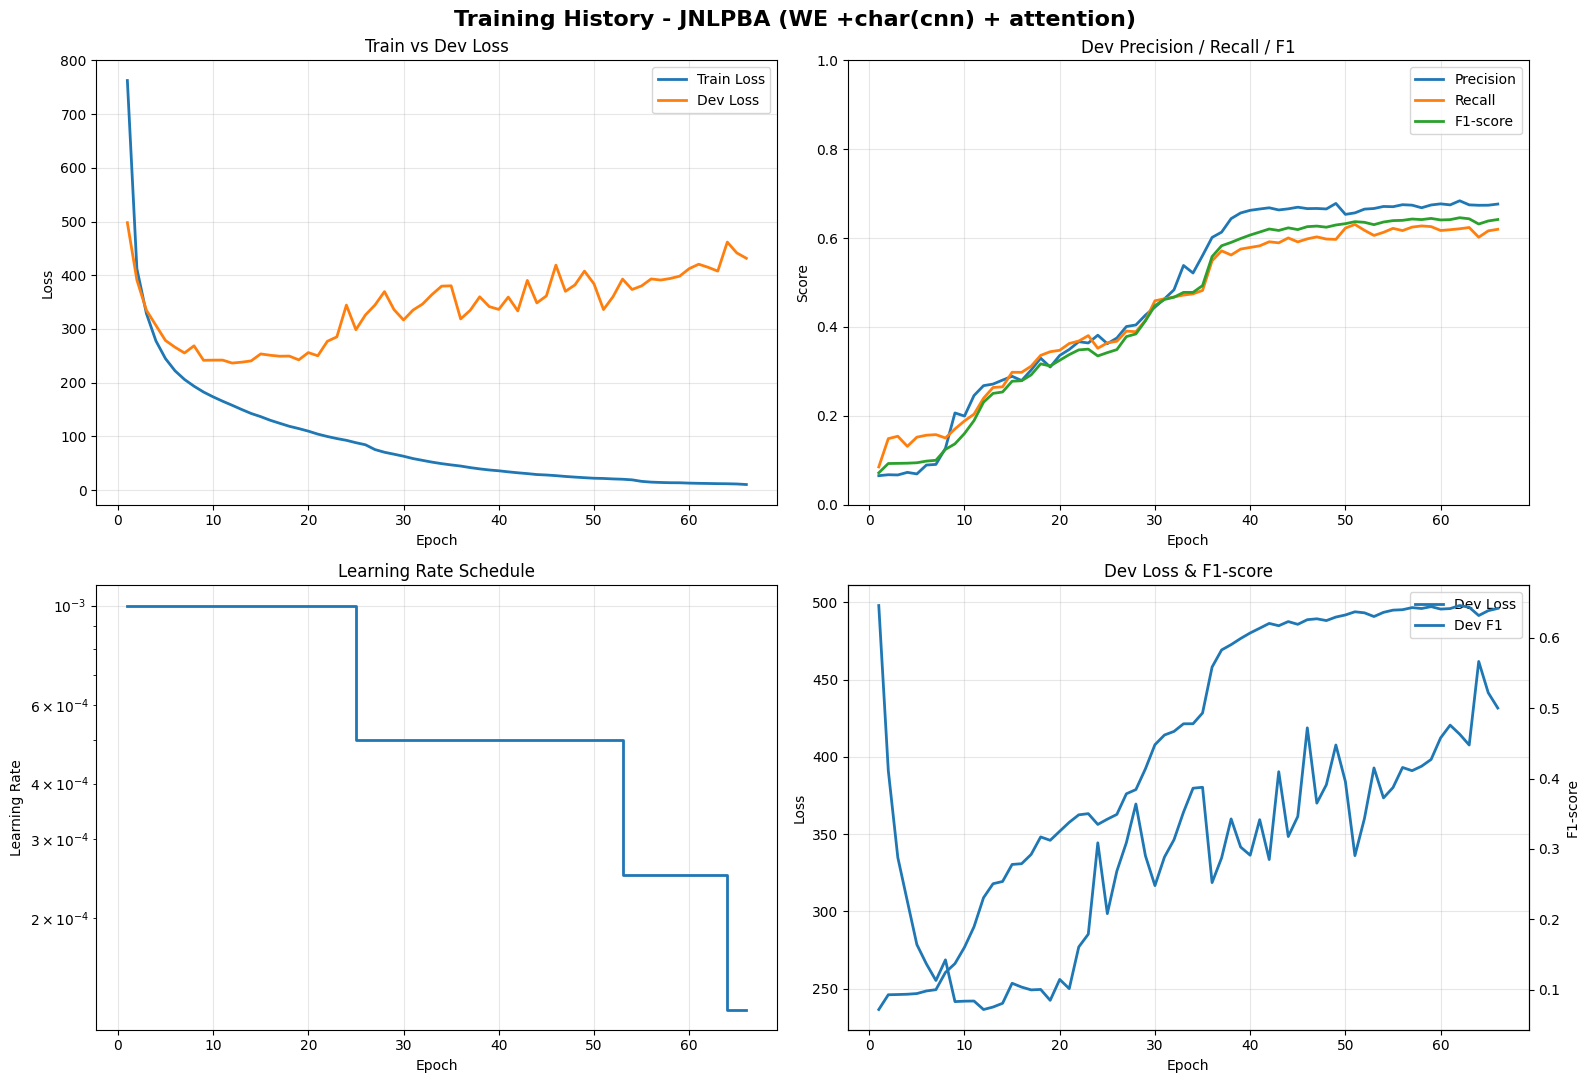


STATISTIQUES FINALES - JNLPBA (WE +char(cnn) + attention)
Meilleur F1 (dev)       : 0.6459
Meilleure Precision(dev): 0.6840
Meilleur Recall (dev)   : 0.6307
Final train loss        : 10.2529
Final dev loss          : 431.6360
Final learning rate     : 0.000125


In [42]:
plot_training_history(history_we_char_cnn_attention, dataset_name="JNLPBA (WE +char(cnn) + attention)")

In [43]:
model_path = "./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt"
model_we_char_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char_cnn_attention, targets_we_char_cnn_attention = predict_on_test_set(
    model=model_we_char_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt
Best F1 enregistré: 0.6459
Époque: 61
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_line        correct
  9 | I-cell_line        | I-cell_line        correct
 10 | I-cell_line        | I-cell_line        correct
 11 | I-cell_line        | I-cell_line        correct
 12 | O                  | O               


Accuracy globale: 0.9027

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


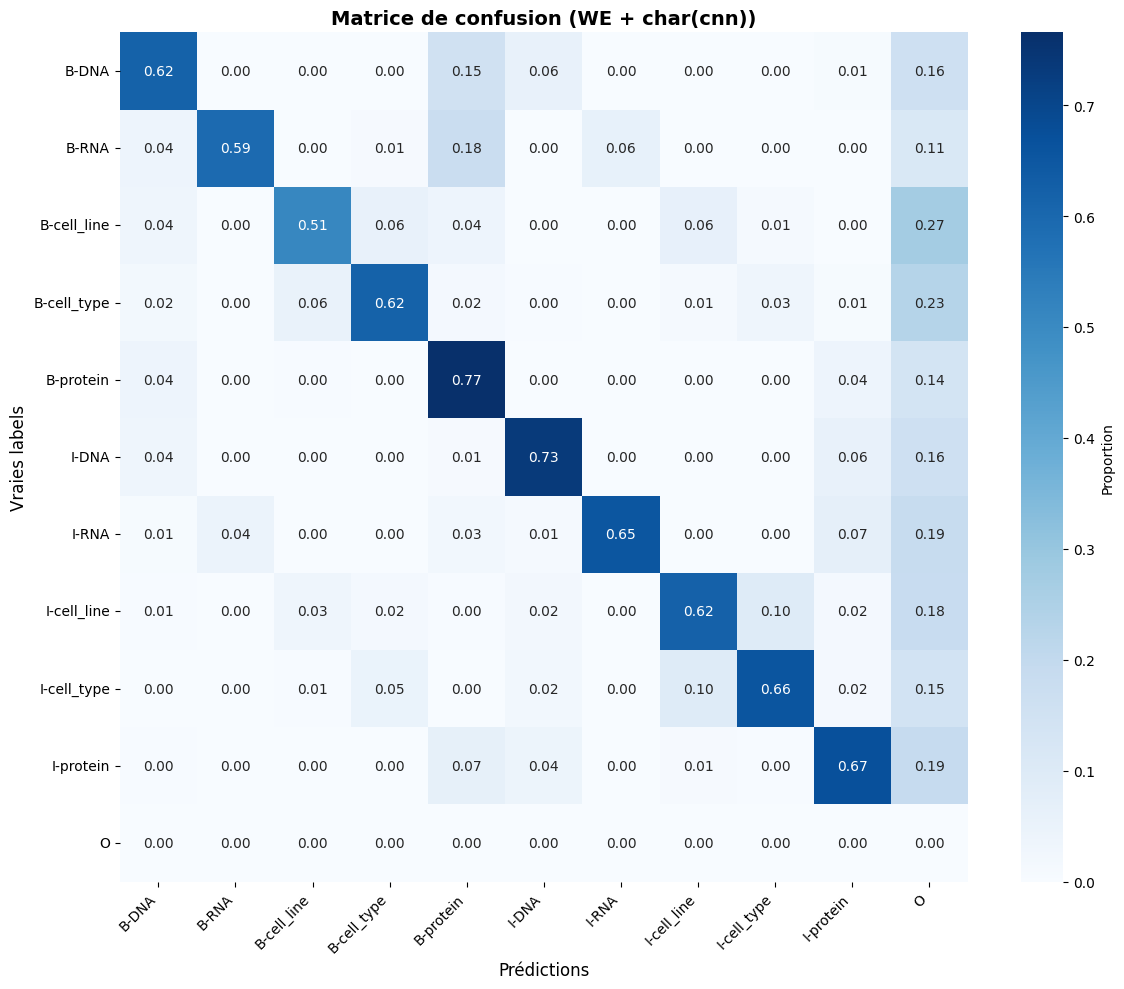

              precision    recall  f1-score   support

       B-DNA       0.63      0.62      0.62       855
       B-RNA       0.78      0.59      0.67        96
 B-cell_line       0.54      0.51      0.52       393
 B-cell_type       0.85      0.62      0.72      1729
   B-protein       0.87      0.77      0.82      4505
       I-DNA       0.76      0.73      0.74      1393
       I-RNA       0.90      0.65      0.76       156
 I-cell_line       0.58      0.62      0.60       792
 I-cell_type       0.92      0.66      0.76      2690
   I-protein       0.89      0.67      0.77      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.68     16829
   macro avg       0.70      0.59      0.63     16829
weighted avg       0.84      0.68      0.75     16829

B-DNA               : Precision=0.627, Recall=0.616, F1=0.622, Support=855
B-RNA               : Precision=0.781, Recall=0.594, F1=0.675, Support=96
B-cell_line         : Precision=0.538,

In [44]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn_attention, predictions_we_char_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']

if set(predictions_we_char_cnn_attention) == set(targets_we_char_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn_attention,
        targets=targets_we_char_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn_attention[:10])}")

WE + char(cnn, bilstm)

In [ ]:
model_we_char_cnn_bilstm, history_we_char_cnn_bilstm = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=4,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,127,072


Training: 100%|██████████| 491/491 [01:08<00:00,  7.13it/s]


Epoch 01/100 | Train loss: 301.4120 | Dev loss: 170.1748 | P: 0.7149 R: 0.6566 F1: 0.6790 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt : (F1: 0.6790)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.19it/s]


Epoch 02/100 | Train loss: 128.6956 | Dev loss: 141.0731 | P: 0.7303 R: 0.6936 F1: 0.7096 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt : (F1: 0.7096)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.18it/s]


Epoch 03/100 | Train loss: 97.1556 | Dev loss: 129.4199 | P: 0.7318 R: 0.7285 F1: 0.7282 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt : (F1: 0.7282)


Training: 100%|██████████| 491/491 [01:11<00:00,  6.86it/s]


Epoch 04/100 | Train loss: 78.6356 | Dev loss: 124.4507 | P: 0.7500 R: 0.6921 F1: 0.7137 | LR: 0.001000


Training: 100%|██████████| 491/491 [03:02<00:00,  2.69it/s]


Epoch 05/100 | Train loss: 65.7830 | Dev loss: 121.7656 | P: 0.7517 R: 0.6992 F1: 0.7228 | LR: 0.001000


Training: 100%|██████████| 491/491 [02:56<00:00,  2.79it/s]


Epoch 06/100 | Train loss: 55.6456 | Dev loss: 121.5602 | P: 0.7494 R: 0.6989 F1: 0.7196 | LR: 0.000500


Training: 100%|██████████| 491/491 [02:44<00:00,  2.99it/s]


Epoch 07/100 | Train loss: 44.0043 | Dev loss: 119.9127 | P: 0.7402 R: 0.7260 F1: 0.7322 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt : (F1: 0.7322)


Training: 100%|██████████| 491/491 [02:58<00:00,  2.75it/s]


Epoch 08/100 | Train loss: 39.0794 | Dev loss: 126.8636 | P: 0.7369 R: 0.7146 F1: 0.7244 | LR: 0.000500


Training: 100%|██████████| 491/491 [02:28<00:00,  3.31it/s]


Epoch 09/100 | Train loss: 35.0492 | Dev loss: 132.4725 | P: 0.7493 R: 0.6912 F1: 0.7170 | LR: 0.000500


Training: 100%|██████████| 491/491 [03:19<00:00,  2.47it/s]


Epoch 10/100 | Train loss: 31.5257 | Dev loss: 139.4730 | P: 0.7273 R: 0.7166 F1: 0.7205 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:50<00:00,  4.44it/s]


Epoch 11/100 | Train loss: 25.2440 | Dev loss: 142.5477 | P: 0.7324 R: 0.7058 F1: 0.7175 | LR: 0.000250

Early stopping triggered après 11 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 141.0844
Precision: 0.6476
Recall: 0.6813
F1-score: 0.6601

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 6: LR = 0.000500
  Epoch 10: LR = 0.000250


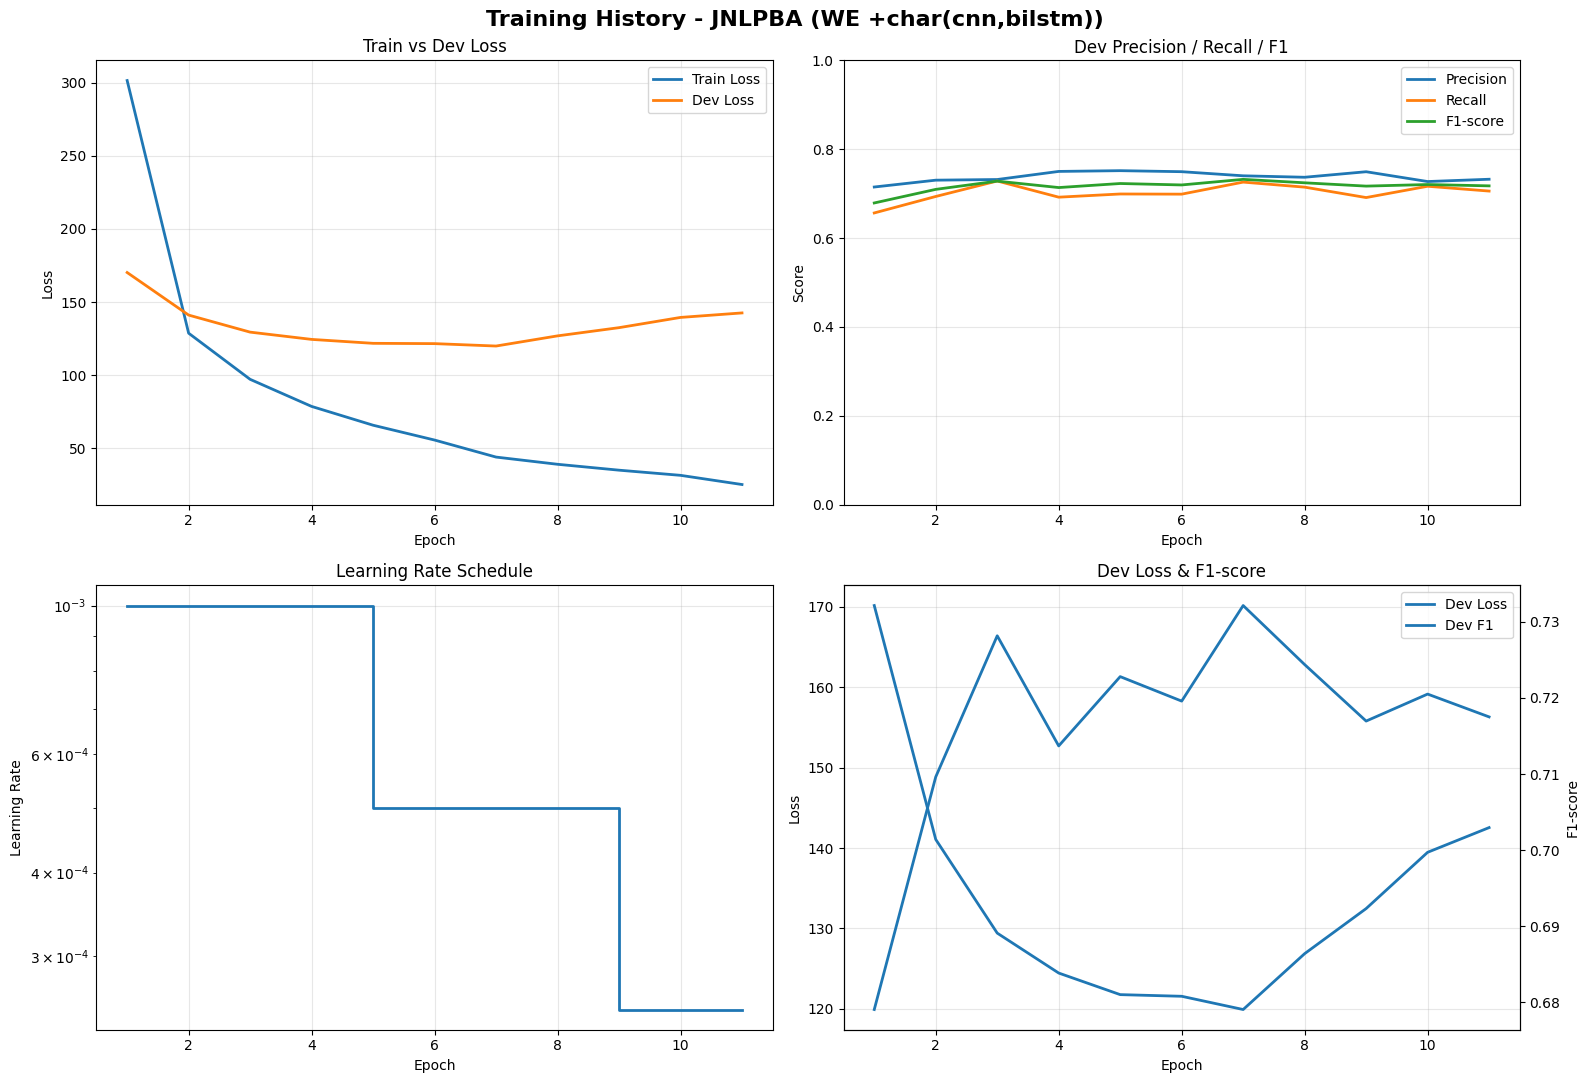


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm))
Meilleur F1 (dev)       : 0.7322
Meilleure Precision(dev): 0.7517
Meilleur Recall (dev)   : 0.7285
Final train loss        : 25.2440
Final dev loss          : 142.5477
Final learning rate     : 0.000250


In [46]:
plot_training_history(history_we_char_cnn_bilstm, dataset_name="JNLPBA (WE +char(cnn,bilstm))")

In [48]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt"
model_we_char__bilstm_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn = predict_on_test_set(
    model=model_we_char__bilstm_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt
Best F1 enregistré: 0.7322
Époque: 6
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-protein          incorrect
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O             


Accuracy globale: 0.9287

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


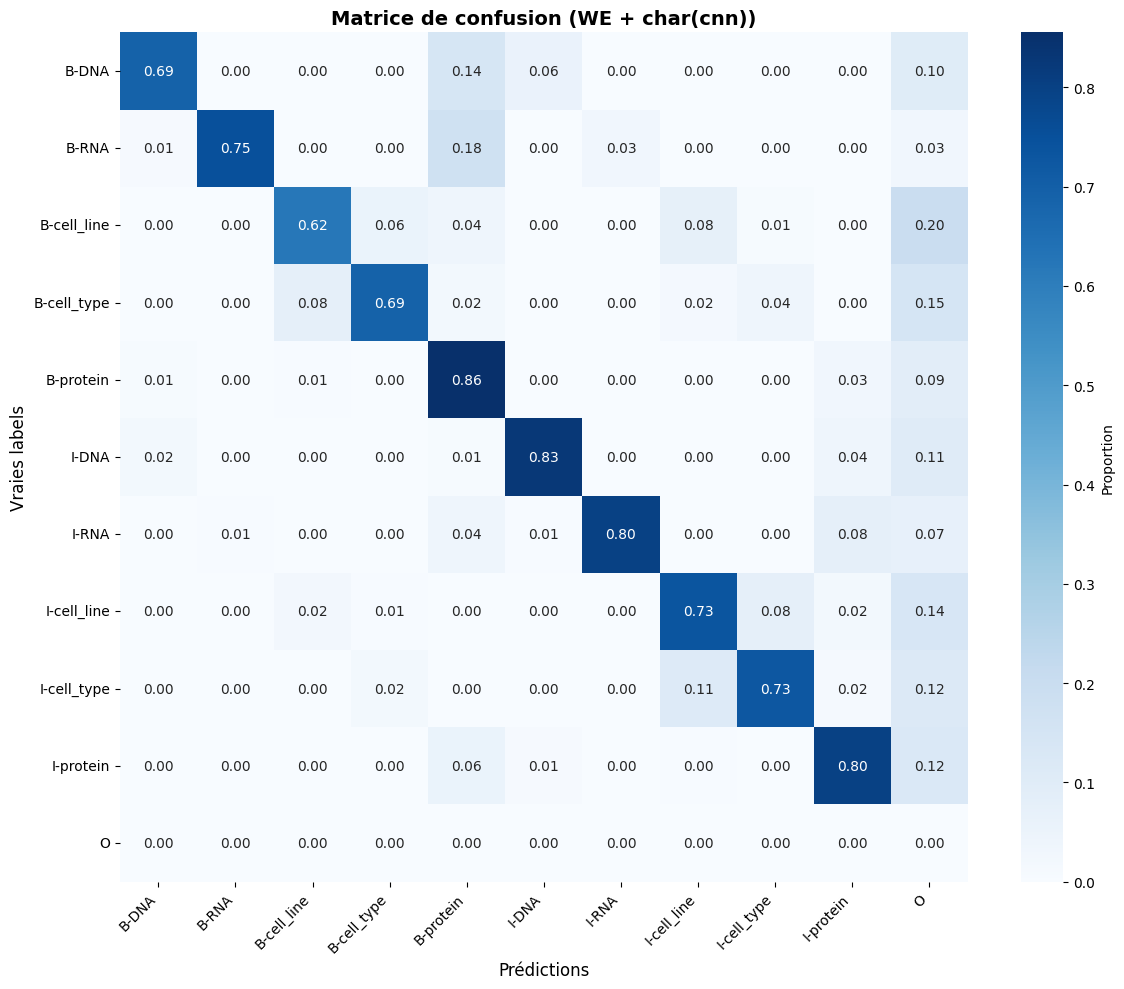

              precision    recall  f1-score   support

       B-DNA       0.89      0.69      0.78       855
       B-RNA       0.87      0.75      0.80        96
 B-cell_line       0.57      0.62      0.59       393
 B-cell_type       0.93      0.69      0.79      1729
   B-protein       0.89      0.86      0.87      4505
       I-DNA       0.92      0.83      0.87      1393
       I-RNA       0.91      0.80      0.85       156
 I-cell_line       0.60      0.73      0.66       792
 I-cell_type       0.93      0.73      0.82      2690
   I-protein       0.92      0.80      0.86      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.78     16829
   macro avg       0.77      0.68      0.72     16829
weighted avg       0.89      0.78      0.83     16829

B-DNA               : Precision=0.887, Recall=0.691, F1=0.777, Support=855
B-RNA               : Precision=0.867, Recall=0.750, F1=0.804, Support=96
B-cell_line         : Precision=0.569,

In [ ]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn, predictions_we_char__bilstm_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']

if set(predictions_we_char__bilstm_cnn) == set(targets_we_char__bilstm_cnn) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn,
        targets=targets_we_char__bilstm_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn[:10])}")

WE + char(cnn, bilstm) + attention

In [ ]:
model_we_char_cnn_bilstm_attention, history_we_char_cnn_bilstm_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=4,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,193,120


Training: 100%|██████████| 491/491 [01:15<00:00,  6.51it/s]


Epoch 01/100 | Train loss: 757.9920 | Dev loss: 497.3390 | P: 0.0624 R: 0.0818 F1: 0.0617 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.0617)


Training: 100%|██████████| 491/491 [01:35<00:00,  5.14it/s]


Epoch 02/100 | Train loss: 413.4012 | Dev loss: 400.6360 | P: 0.0687 R: 0.1276 F1: 0.0893 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.0893)


Training: 100%|██████████| 491/491 [01:18<00:00,  6.24it/s]


Epoch 03/100 | Train loss: 330.4233 | Dev loss: 332.3608 | P: 0.0689 R: 0.1477 F1: 0.0938 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.0938)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.76it/s]


Epoch 04/100 | Train loss: 280.1540 | Dev loss: 300.5446 | P: 0.0670 R: 0.1545 F1: 0.0932 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:08<00:00,  7.12it/s]


Epoch 05/100 | Train loss: 249.0338 | Dev loss: 282.6330 | P: 0.0874 R: 0.1473 F1: 0.0959 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.0959)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.14it/s]


Epoch 06/100 | Train loss: 226.6920 | Dev loss: 268.6947 | P: 0.1008 R: 0.1514 F1: 0.0993 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.0993)


Training: 100%|██████████| 491/491 [01:10<00:00,  6.93it/s]


Epoch 07/100 | Train loss: 211.2025 | Dev loss: 257.1370 | P: 0.0975 R: 0.1576 F1: 0.1019 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.1019)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.77it/s]


Epoch 08/100 | Train loss: 200.2747 | Dev loss: 253.3524 | P: 0.1169 R: 0.1540 F1: 0.1194 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.1194)


Training: 100%|██████████| 491/491 [01:09<00:00,  7.10it/s]


Epoch 09/100 | Train loss: 191.4735 | Dev loss: 277.3661 | P: 0.1265 R: 0.1457 F1: 0.1301 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.1301)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.14it/s]


Epoch 10/100 | Train loss: 183.0698 | Dev loss: 251.3947 | P: 0.2027 R: 0.1613 F1: 0.1303 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.1303)


Training: 100%|██████████| 491/491 [02:37<00:00,  3.11it/s]


Epoch 11/100 | Train loss: 176.9042 | Dev loss: 283.3834 | P: 0.2364 R: 0.1617 F1: 0.1447 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.1447)


Training: 100%|██████████| 491/491 [01:22<00:00,  5.93it/s]


Epoch 12/100 | Train loss: 169.0661 | Dev loss: 234.1773 | P: 0.2040 R: 0.1860 F1: 0.1543 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.1543)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.73it/s]


Epoch 13/100 | Train loss: 162.4427 | Dev loss: 284.9005 | P: 0.2129 R: 0.1741 F1: 0.1771 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.1771)


Training: 100%|██████████| 491/491 [01:26<00:00,  5.71it/s]


Epoch 14/100 | Train loss: 155.3222 | Dev loss: 240.3144 | P: 0.2960 R: 0.2488 F1: 0.2438 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.2438)


Training: 100%|██████████| 491/491 [01:11<00:00,  6.83it/s]


Epoch 15/100 | Train loss: 148.2296 | Dev loss: 234.6131 | P: 0.2671 R: 0.2610 F1: 0.2497 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.2497)


Training: 100%|██████████| 491/491 [01:09<00:00,  7.06it/s]


Epoch 16/100 | Train loss: 141.5597 | Dev loss: 267.1806 | P: 0.2580 R: 0.2392 F1: 0.2419 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:27<00:00,  5.64it/s]


Epoch 17/100 | Train loss: 135.9527 | Dev loss: 230.9489 | P: 0.3056 R: 0.3046 F1: 0.2896 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.2896)


Training: 100%|██████████| 491/491 [01:29<00:00,  5.51it/s]


Epoch 18/100 | Train loss: 129.8689 | Dev loss: 237.2856 | P: 0.3024 R: 0.3035 F1: 0.2858 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:19<00:00,  6.21it/s]


Epoch 19/100 | Train loss: 124.0556 | Dev loss: 260.6772 | P: 0.3262 R: 0.3214 F1: 0.3116 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.3116)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.74it/s]


Epoch 20/100 | Train loss: 118.7125 | Dev loss: 268.3691 | P: 0.3339 R: 0.3161 F1: 0.3134 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.3134)


Training: 100%|██████████| 491/491 [01:13<00:00,  6.68it/s]


Epoch 21/100 | Train loss: 115.1146 | Dev loss: 278.7305 | P: 0.3334 R: 0.3098 F1: 0.3096 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:12<00:00,  6.79it/s]


Epoch 22/100 | Train loss: 109.6032 | Dev loss: 263.3774 | P: 0.3782 R: 0.3607 F1: 0.3550 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.3550)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.80it/s]


Epoch 23/100 | Train loss: 104.6691 | Dev loss: 291.0869 | P: 0.3824 R: 0.3524 F1: 0.3450 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:14<00:00,  6.61it/s]


Epoch 24/100 | Train loss: 102.4029 | Dev loss: 271.0837 | P: 0.3932 R: 0.3868 F1: 0.3746 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.3746)


Training: 100%|██████████| 491/491 [01:14<00:00,  6.60it/s]


Epoch 25/100 | Train loss: 95.8991 | Dev loss: 273.7227 | P: 0.3780 R: 0.3756 F1: 0.3624 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:11<00:00,  6.90it/s]


Epoch 26/100 | Train loss: 91.1745 | Dev loss: 272.7892 | P: 0.3923 R: 0.4017 F1: 0.3869 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.3869)


Training: 100%|██████████| 491/491 [01:09<00:00,  7.02it/s]


Epoch 27/100 | Train loss: 85.8951 | Dev loss: 276.4861 | P: 0.3853 R: 0.3916 F1: 0.3735 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:22<00:00,  5.93it/s]


Epoch 28/100 | Train loss: 81.5837 | Dev loss: 299.5351 | P: 0.4137 R: 0.4004 F1: 0.3963 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.3963)


Training: 100%|██████████| 491/491 [01:16<00:00,  6.40it/s]


Epoch 29/100 | Train loss: 76.0201 | Dev loss: 259.4701 | P: 0.4287 R: 0.4431 F1: 0.4320 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.4320)


Training: 100%|██████████| 491/491 [01:11<00:00,  6.82it/s]


Epoch 30/100 | Train loss: 70.4541 | Dev loss: 279.0095 | P: 0.4538 R: 0.4542 F1: 0.4515 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.4515)


Training: 100%|██████████| 491/491 [01:15<00:00,  6.53it/s]


Epoch 31/100 | Train loss: 64.5733 | Dev loss: 286.8165 | P: 0.5460 R: 0.4669 F1: 0.4684 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.4684)


Training: 100%|██████████| 491/491 [01:23<00:00,  5.86it/s]


Epoch 32/100 | Train loss: 59.6453 | Dev loss: 319.4091 | P: 0.6495 R: 0.4458 F1: 0.4523 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:16<00:00,  6.45it/s]


Epoch 33/100 | Train loss: 54.8944 | Dev loss: 277.0096 | P: 0.5693 R: 0.4948 F1: 0.5032 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.5032)


Training: 100%|██████████| 491/491 [01:29<00:00,  5.51it/s]


Epoch 34/100 | Train loss: 50.7704 | Dev loss: 281.6810 | P: 0.6263 R: 0.5572 F1: 0.5808 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.5808)


Training: 100%|██████████| 491/491 [01:19<00:00,  6.21it/s]


Epoch 35/100 | Train loss: 47.7336 | Dev loss: 284.9507 | P: 0.6552 R: 0.5549 F1: 0.5867 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.5867)


Training: 100%|██████████| 491/491 [01:17<00:00,  6.32it/s]


Epoch 36/100 | Train loss: 45.2572 | Dev loss: 261.9404 | P: 0.6589 R: 0.5772 F1: 0.6021 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.6021)


Training: 100%|██████████| 491/491 [01:13<00:00,  6.67it/s]


Epoch 37/100 | Train loss: 41.7972 | Dev loss: 285.4324 | P: 0.6512 R: 0.5635 F1: 0.5965 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:16<00:00,  6.39it/s]


Epoch 38/100 | Train loss: 38.5651 | Dev loss: 274.5652 | P: 0.6693 R: 0.5935 F1: 0.6206 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.6206)


Training: 100%|██████████| 491/491 [01:15<00:00,  6.49it/s]


Epoch 39/100 | Train loss: 35.9438 | Dev loss: 304.5049 | P: 0.6637 R: 0.5796 F1: 0.6108 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:16<00:00,  6.43it/s]


Epoch 40/100 | Train loss: 35.0877 | Dev loss: 277.7365 | P: 0.6635 R: 0.5912 F1: 0.6173 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:16<00:00,  6.41it/s]


Epoch 41/100 | Train loss: 32.8930 | Dev loss: 271.6028 | P: 0.6770 R: 0.5957 F1: 0.6229 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.6229)


Training: 100%|██████████| 491/491 [01:25<00:00,  5.76it/s]


Epoch 42/100 | Train loss: 30.7629 | Dev loss: 289.9816 | P: 0.6665 R: 0.6113 F1: 0.6331 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.6331)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.75it/s]


Epoch 43/100 | Train loss: 28.4248 | Dev loss: 276.3503 | P: 0.6612 R: 0.6020 F1: 0.6256 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:08<00:00,  7.13it/s]


Epoch 44/100 | Train loss: 26.9092 | Dev loss: 306.7908 | P: 0.6586 R: 0.6051 F1: 0.6264 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:08<00:00,  7.19it/s]


Epoch 45/100 | Train loss: 25.6361 | Dev loss: 297.7881 | P: 0.6612 R: 0.5835 F1: 0.6137 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:08<00:00,  7.16it/s]


Epoch 46/100 | Train loss: 21.1976 | Dev loss: 296.0193 | P: 0.6701 R: 0.6153 F1: 0.6365 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt : (F1: 0.6365)


Training: 100%|██████████| 491/491 [01:09<00:00,  7.07it/s]


Epoch 47/100 | Train loss: 18.4592 | Dev loss: 309.4939 | P: 0.6607 R: 0.6082 F1: 0.6279 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:08<00:00,  7.17it/s]


Epoch 48/100 | Train loss: 17.3386 | Dev loss: 333.0764 | P: 0.6631 R: 0.6097 F1: 0.6309 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:08<00:00,  7.20it/s]


Epoch 49/100 | Train loss: 16.6072 | Dev loss: 321.8564 | P: 0.6583 R: 0.6127 F1: 0.6291 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:12<00:00,  6.74it/s]


Epoch 50/100 | Train loss: 15.0572 | Dev loss: 342.5939 | P: 0.6667 R: 0.6064 F1: 0.6300 | LR: 0.000250

Early stopping triggered après 50 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 343.2550
Precision: 0.5951
Recall: 0.6121
F1-score: 0.5992

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 45: LR = 0.000500
  Epoch 49: LR = 0.000250


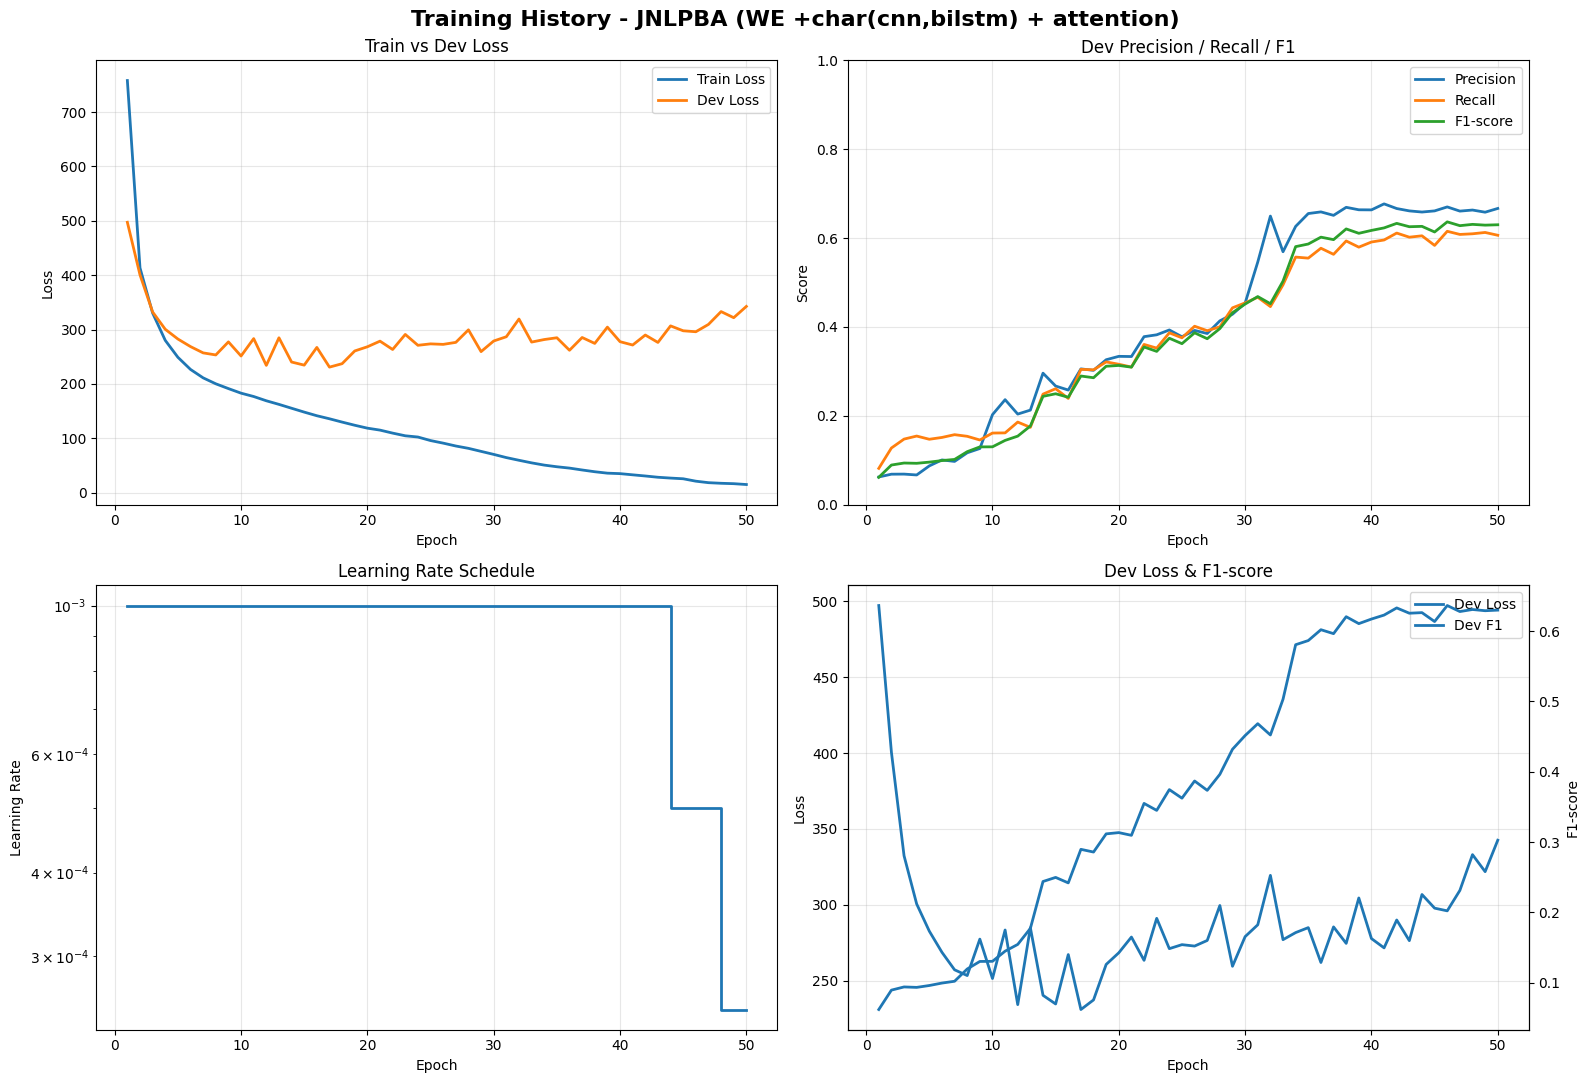


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + attention)
Meilleur F1 (dev)       : 0.6365
Meilleure Precision(dev): 0.6770
Meilleur Recall (dev)   : 0.6153
Final train loss        : 15.0572
Final dev loss          : 342.5939
Final learning rate     : 0.000250


In [51]:
plot_training_history(history_we_char_cnn_bilstm_attention, dataset_name="JNLPBA (WE +char(cnn,bilstm) + attention)")

In [52]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt"
model_we_char__bilstm_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt
Best F1 enregistré: 0.6365
Époque: 45
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O  


Accuracy globale: 0.9094

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


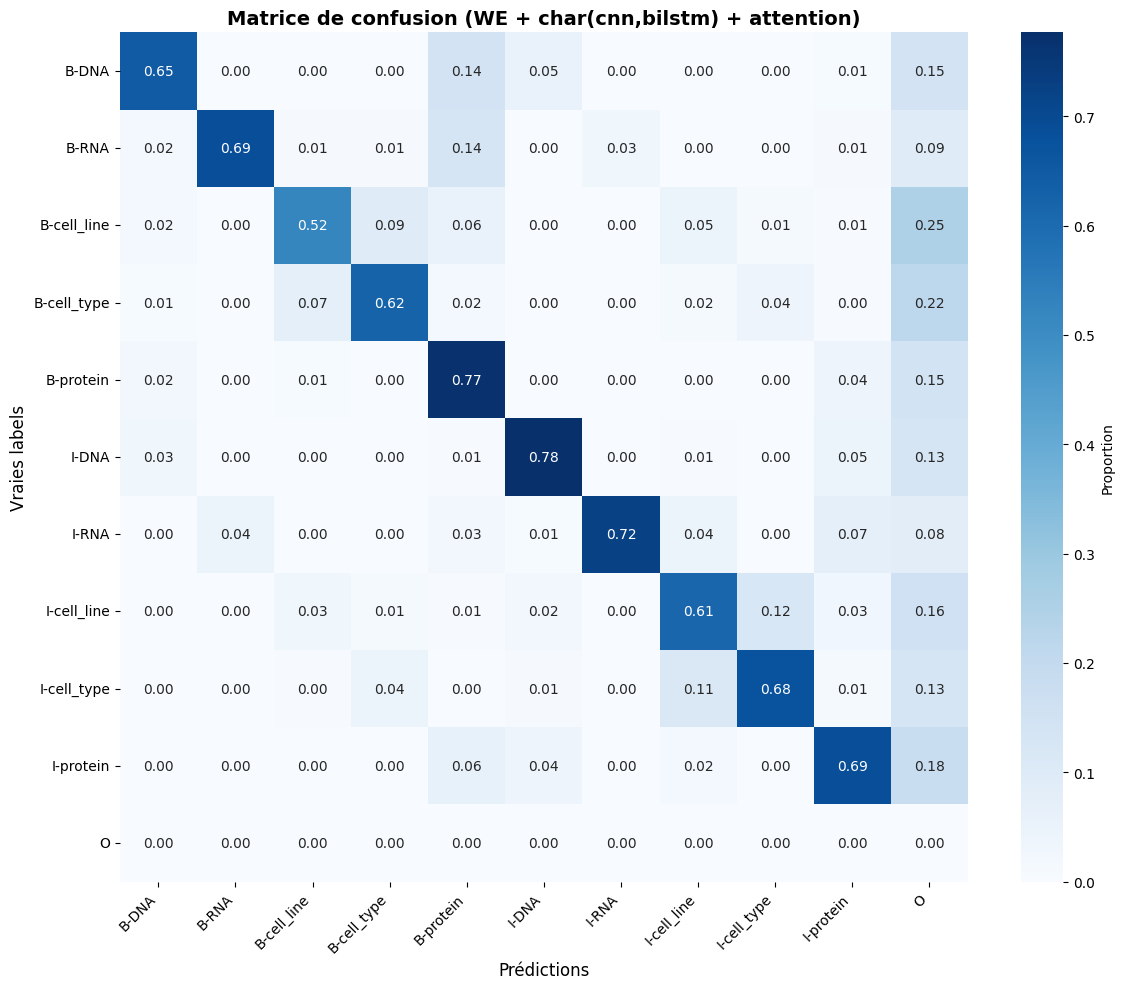

              precision    recall  f1-score   support

       B-DNA       0.75      0.65      0.69       855
       B-RNA       0.80      0.69      0.74        96
 B-cell_line       0.50      0.52      0.51       393
 B-cell_type       0.86      0.62      0.72      1729
   B-protein       0.88      0.77      0.82      4505
       I-DNA       0.80      0.78      0.79      1393
       I-RNA       0.92      0.72      0.81       156
 I-cell_line       0.51      0.61      0.56       792
 I-cell_type       0.91      0.68      0.77      2690
   I-protein       0.90      0.69      0.78      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.70     16829
   macro avg       0.71      0.61      0.65     16829
weighted avg       0.85      0.70      0.76     16829

B-DNA               : Precision=0.747, Recall=0.647, F1=0.693, Support=855
B-RNA               : Precision=0.805, Recall=0.688, F1=0.742, Support=96
B-cell_line         : Precision=0.498,

In [53]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention, predictions_we_char__bilstm_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention) == set(targets_we_char__bilstm_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention,
        targets=targets_we_char__bilstm_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention[:10])}")

WE + char(cnn, bilstm) + attention + fully connected network

In [ ]:
model_we_char_cnn_bilstm_attention_fc, history_we_char_cnn_bilstm_attention_fc = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=4,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,071,816


Training: 100%|██████████| 491/491 [01:09<00:00,  7.05it/s]


Epoch 01/100 | Train loss: 756.8893 | Dev loss: 498.3866 | P: 0.0648 R: 0.1082 F1: 0.0797 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.0797)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.15it/s]


Epoch 02/100 | Train loss: 418.9025 | Dev loss: 392.0515 | P: 0.0693 R: 0.1394 F1: 0.0926 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.0926)


Training: 100%|██████████| 491/491 [01:09<00:00,  7.06it/s]


Epoch 03/100 | Train loss: 337.2755 | Dev loss: 332.9401 | P: 0.0684 R: 0.1475 F1: 0.0932 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.0932)


Training: 100%|██████████| 491/491 [01:11<00:00,  6.87it/s]


Epoch 04/100 | Train loss: 286.4976 | Dev loss: 297.6428 | P: 0.0667 R: 0.1542 F1: 0.0925 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:13<00:00,  6.65it/s]


Epoch 05/100 | Train loss: 253.2166 | Dev loss: 275.1121 | P: 0.1145 R: 0.1519 F1: 0.0978 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.0978)


Training: 100%|██████████| 491/491 [01:18<00:00,  6.25it/s]


Epoch 06/100 | Train loss: 230.3865 | Dev loss: 262.1768 | P: 0.1098 R: 0.1549 F1: 0.1046 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.1046)


Training: 100%|██████████| 491/491 [01:26<00:00,  5.70it/s]


Epoch 07/100 | Train loss: 215.2602 | Dev loss: 250.5243 | P: 0.1170 R: 0.1587 F1: 0.1123 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.1123)


Training: 100%|██████████| 491/491 [01:21<00:00,  6.06it/s]


Epoch 08/100 | Train loss: 202.8771 | Dev loss: 244.4426 | P: 0.1139 R: 0.1594 F1: 0.1219 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.1219)


Training: 100%|██████████| 491/491 [01:22<00:00,  5.96it/s]


Epoch 09/100 | Train loss: 193.1442 | Dev loss: 285.9506 | P: 0.2226 R: 0.1467 F1: 0.1332 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.1332)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.77it/s]


Epoch 10/100 | Train loss: 185.0327 | Dev loss: 237.0068 | P: 0.1713 R: 0.1647 F1: 0.1144 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:18<00:00,  6.24it/s]


Epoch 11/100 | Train loss: 176.4360 | Dev loss: 235.6321 | P: 0.2435 R: 0.2036 F1: 0.1976 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.1976)


Training: 100%|██████████| 491/491 [01:19<00:00,  6.18it/s]


Epoch 12/100 | Train loss: 168.3262 | Dev loss: 232.8790 | P: 0.2473 R: 0.2189 F1: 0.2116 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.2116)


Training: 100%|██████████| 491/491 [01:17<00:00,  6.35it/s]


Epoch 13/100 | Train loss: 158.6877 | Dev loss: 223.5111 | P: 0.2724 R: 0.2555 F1: 0.2470 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.2470)


Training: 100%|██████████| 491/491 [01:15<00:00,  6.48it/s]


Epoch 14/100 | Train loss: 149.4618 | Dev loss: 210.5144 | P: 0.3131 R: 0.3253 F1: 0.3067 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.3067)


Training: 100%|██████████| 491/491 [01:08<00:00,  7.15it/s]


Epoch 15/100 | Train loss: 134.9182 | Dev loss: 190.3907 | P: 0.3681 R: 0.3954 F1: 0.3634 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.3634)


Training: 100%|██████████| 491/491 [01:13<00:00,  6.66it/s]


Epoch 16/100 | Train loss: 115.3911 | Dev loss: 179.7357 | P: 0.4331 R: 0.4296 F1: 0.4128 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.4128)


Training: 100%|██████████| 491/491 [01:40<00:00,  4.88it/s]


Epoch 17/100 | Train loss: 101.4490 | Dev loss: 172.1028 | P: 0.6576 R: 0.5344 F1: 0.5607 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.5607)


Training: 100%|██████████| 491/491 [01:17<00:00,  6.32it/s]


Epoch 18/100 | Train loss: 90.7157 | Dev loss: 150.7331 | P: 0.6885 R: 0.5917 F1: 0.6135 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6135)


Training: 100%|██████████| 491/491 [01:23<00:00,  5.92it/s]


Epoch 19/100 | Train loss: 82.4304 | Dev loss: 155.9022 | P: 0.7156 R: 0.6046 F1: 0.6404 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6404)


Training: 100%|██████████| 491/491 [01:22<00:00,  5.95it/s]


Epoch 20/100 | Train loss: 76.4081 | Dev loss: 153.8814 | P: 0.6861 R: 0.6505 F1: 0.6596 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6596)


Training: 100%|██████████| 491/491 [01:25<00:00,  5.74it/s]


Epoch 21/100 | Train loss: 71.3685 | Dev loss: 152.7346 | P: 0.7147 R: 0.6317 F1: 0.6603 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6603)


Training: 100%|██████████| 491/491 [01:14<00:00,  6.56it/s]


Epoch 22/100 | Train loss: 67.3260 | Dev loss: 144.4178 | P: 0.7061 R: 0.6484 F1: 0.6672 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6672)


Training: 100%|██████████| 491/491 [01:14<00:00,  6.63it/s]


Epoch 23/100 | Train loss: 63.8476 | Dev loss: 148.0907 | P: 0.7027 R: 0.6732 F1: 0.6833 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6833)


Training: 100%|██████████| 491/491 [01:17<00:00,  6.37it/s]


Epoch 24/100 | Train loss: 61.0638 | Dev loss: 147.3250 | P: 0.7097 R: 0.6781 F1: 0.6909 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6909)


Training: 100%|██████████| 491/491 [01:24<00:00,  5.82it/s]


Epoch 25/100 | Train loss: 58.1319 | Dev loss: 150.5485 | P: 0.7156 R: 0.6696 F1: 0.6895 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:16<00:00,  6.41it/s]


Epoch 26/100 | Train loss: 56.2707 | Dev loss: 153.4921 | P: 0.7050 R: 0.6788 F1: 0.6897 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:20<00:00,  6.07it/s]


Epoch 27/100 | Train loss: 54.1539 | Dev loss: 151.3029 | P: 0.6965 R: 0.6857 F1: 0.6890 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:20<00:00,  6.09it/s]


Epoch 28/100 | Train loss: 49.0904 | Dev loss: 150.5853 | P: 0.6986 R: 0.6924 F1: 0.6938 | LR: 0.000500
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt : (F1: 0.6938)


Training: 100%|██████████| 491/491 [01:16<00:00,  6.45it/s]


Epoch 29/100 | Train loss: 46.3616 | Dev loss: 154.8044 | P: 0.7043 R: 0.6853 F1: 0.6926 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:13<00:00,  6.70it/s]


Epoch 30/100 | Train loss: 45.4284 | Dev loss: 156.0553 | P: 0.7027 R: 0.6760 F1: 0.6871 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:14<00:00,  6.56it/s]


Epoch 31/100 | Train loss: 44.5254 | Dev loss: 167.8327 | P: 0.7180 R: 0.6541 F1: 0.6819 | LR: 0.000250


Training: 100%|██████████| 491/491 [01:12<00:00,  6.77it/s]


Epoch 32/100 | Train loss: 41.6146 | Dev loss: 166.2815 | P: 0.7023 R: 0.6760 F1: 0.6867 | LR: 0.000250

Early stopping triggered après 32 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 168.3084
Precision: 0.6068
Recall: 0.6781
F1-score: 0.6343

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 27: LR = 0.000500
  Epoch 31: LR = 0.000250


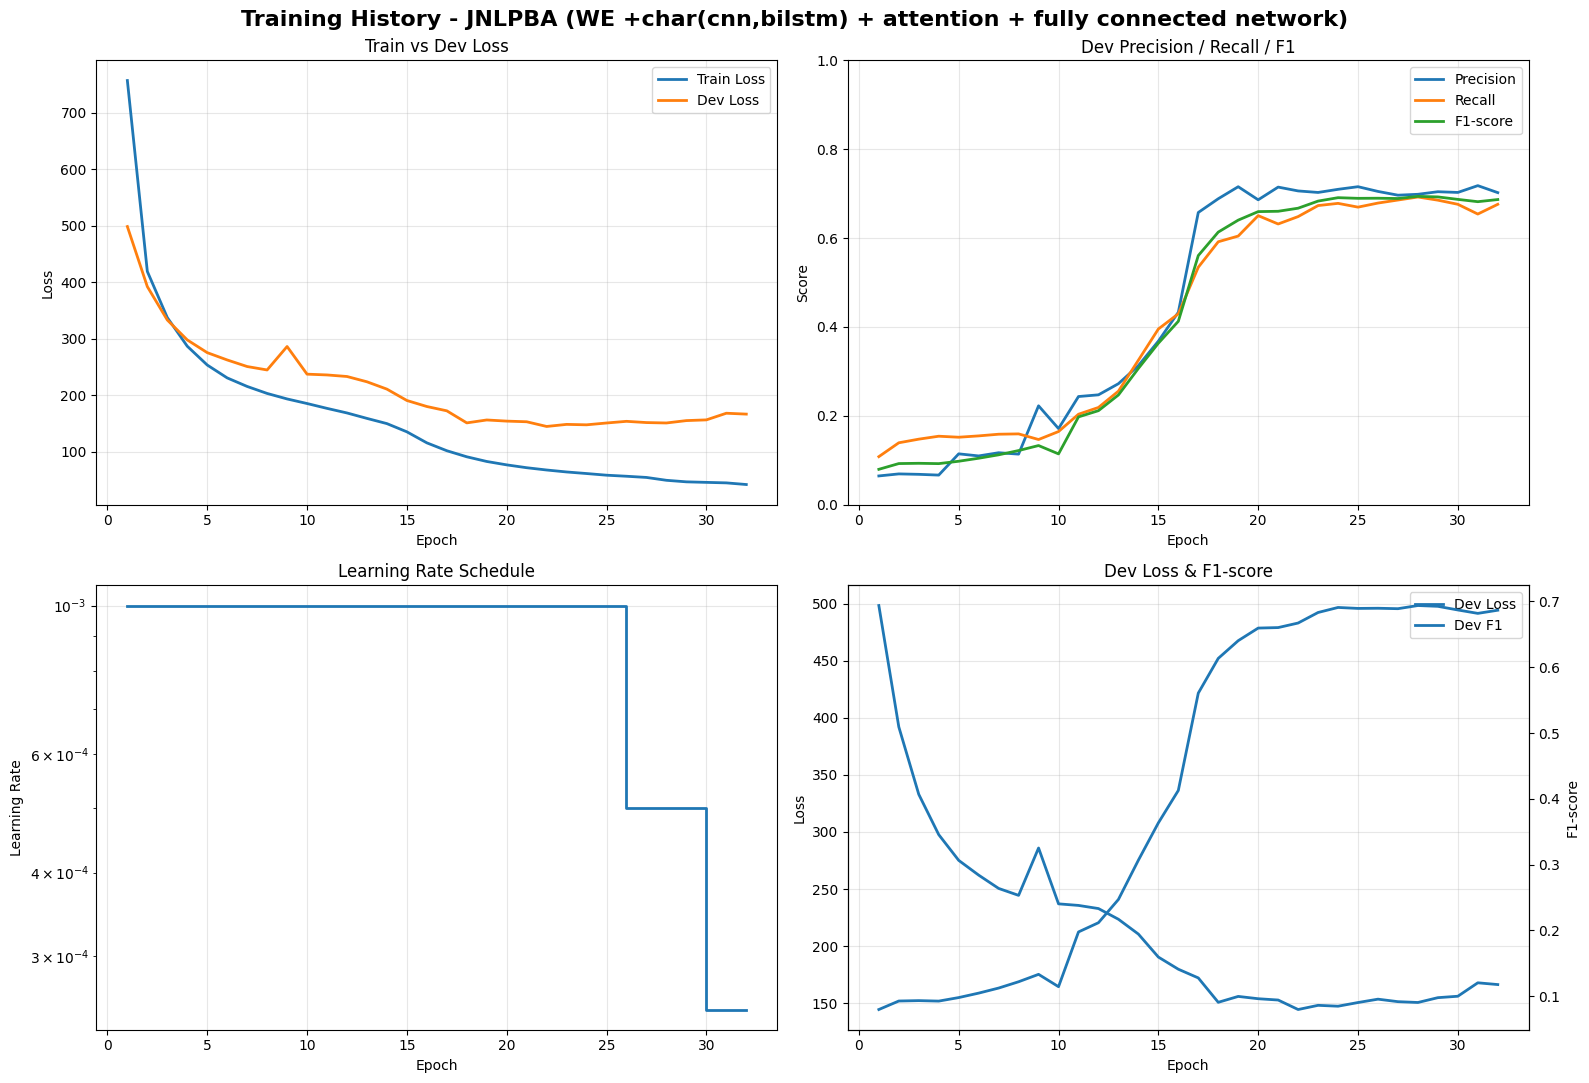


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + attention + fully connected network)
Meilleur F1 (dev)       : 0.6938
Meilleure Precision(dev): 0.7180
Meilleur Recall (dev)   : 0.6924
Final train loss        : 41.6146
Final dev loss          : 166.2815
Final learning rate     : 0.000250


In [55]:
plot_training_history(history_we_char_cnn_bilstm_attention_fc, dataset_name="JNLPBA (WE +char(cnn,bilstm) + attention + fully connected network)")

In [56]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt"
model_we_char__bilstm_cnn_attention_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt
Best F1 enregistré: 0.6938
Époque: 27
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | 


Accuracy globale: 0.9165

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87700
  Entity tokens: 16829
  Unique entity tags in targets: {'I-cell_type', 'B-cell_line', 'I-RNA', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Unique entity tags in predictions: {'I-cell_type', 'B-cell_line', 'I-RNA', 'O', 'I-protein', 'B-cell_type', 'B-RNA', 'I-cell_line', 'B-DNA', 'I-DNA', 'B-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


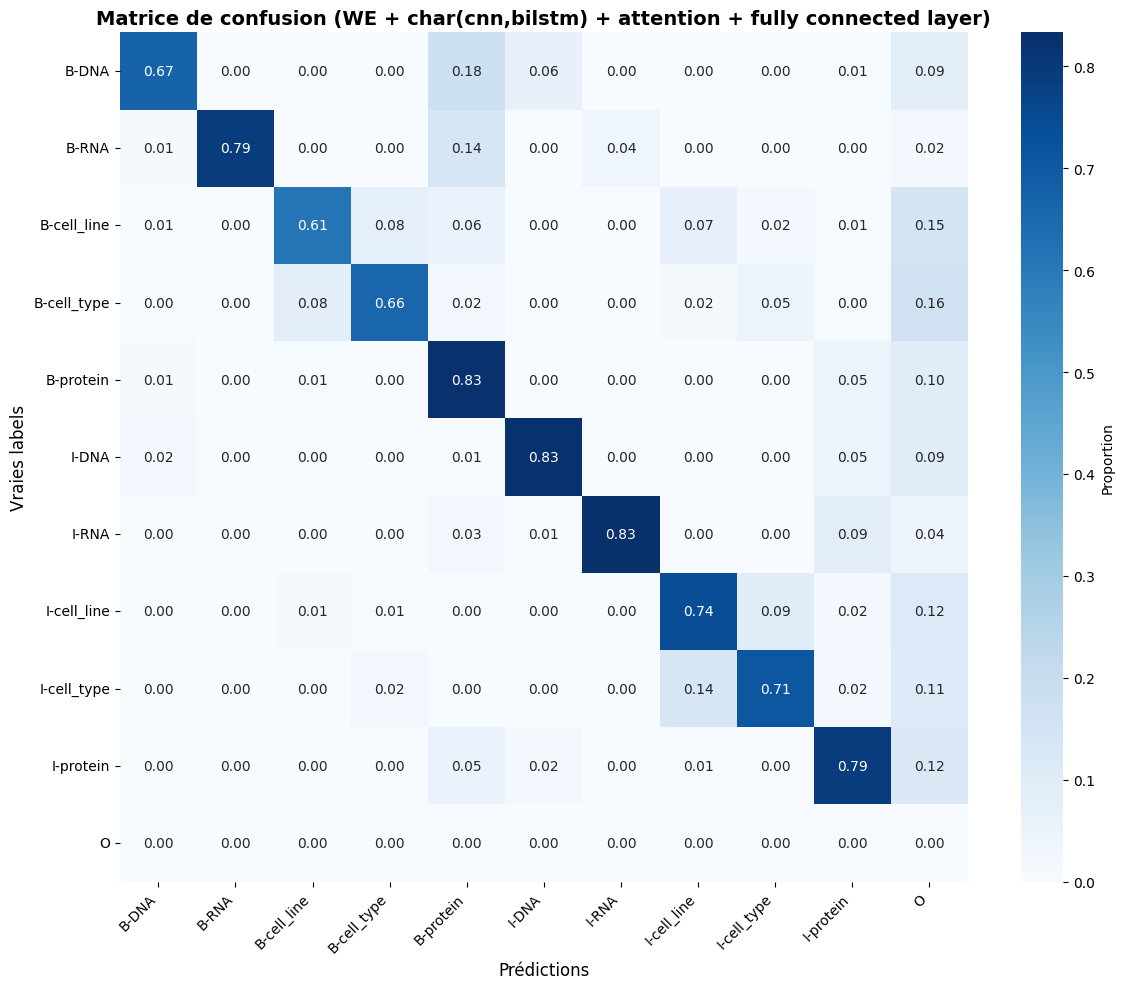

              precision    recall  f1-score   support

       B-DNA       0.85      0.67      0.75       855
       B-RNA       0.90      0.79      0.84        96
 B-cell_line       0.56      0.61      0.58       393
 B-cell_type       0.91      0.66      0.76      1729
   B-protein       0.89      0.83      0.86      4505
       I-DNA       0.90      0.83      0.86      1393
       I-RNA       0.88      0.83      0.86       156
 I-cell_line       0.56      0.74      0.64       792
 I-cell_type       0.92      0.71      0.80      2690
   I-protein       0.89      0.79      0.84      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.77     16829
   macro avg       0.75      0.68      0.71     16829
weighted avg       0.87      0.77      0.81     16829

B-DNA               : Precision=0.847, Recall=0.668, F1=0.747, Support=855
B-RNA               : Precision=0.905, Recall=0.792, F1=0.844, Support=96
B-cell_line         : Precision=0.558,

In [57]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc, predictions_we_char__bilstm_cnn_attention_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention_fc) == set(targets_we_char__bilstm_cnn_attention_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention_fc,
        targets=targets_we_char__bilstm_cnn_attention_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + attention + fully connected layer)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc[:10])}")

Test on a set of examples

In [16]:
import torch

# =========================
# 1. Chargement checkpoint
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# =========================
# 2. Récupération EXACTE des objets du training
# =========================
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_jnlpba["train_loader"]
vocab        = results_jnlpba["vocab"]
char_vocab   = results_jnlpba["char_vocab"]
tag_to_idx   = results_jnlpba["tag_to_idx"]
idx_to_tag   = results_jnlpba["idx_to_tag"]

# =========================
# 3. Reconstruction du modèle (IDENTIQUE au training)
# =========================
model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_jnlpba["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=256,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# =========================
# 4. Fonction de prédiction CORRECTE
# =========================
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



# =========================
# 5. Tes phrases de test
# =========================
test_data = [
    # Protein + Cell line
    (
        ["Octamer-binding", "proteins", "from", "HeLa", "cells", "stimulate", "transcription"],
        ["B-protein", "I-protein", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA example
    (
        ["The", "BRCA1", "gene", "is", "associated", "with", "breast", "cancer"],
        ["O", "B-DNA", "O", "O", "O", "O", "B-cell_type", "O"]
    ),
    # RNA example
    (
        ["mRNA", "expression", "in", "Jurkat", "cells", "was", "upregulated"],
        ["B-RNA", "O", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # Cell type example
    (
        ["T", "lymphocytes", "play", "a", "key", "role", "in", "immune", "response"],
        ["B-cell_type", "I-cell_type", "O", "O", "O", "O", "O", "O", "O"]
    ),
    # Overlapping adjacent entities
    (
        ["p53", "and", "BRCA1", "regulate", "DNA", "replication"],
        ["B-protein", "O", "B-DNA", "O", "B-DNA", "O"]
    ),
    # Mixed entities
    (
        ["The", "RNA", "of", "Jurkat", "T", "cells", "is", "similar", "to", "HeLa", "cells"],
        ["O", "B-RNA", "O", "B-cell_line", "B-cell_type", "I-cell_line", "O", "O", "O", "B-cell_line", "I-cell_line"]
    ),
    # Long sentence with multiple types
    (
        ["p53", "protein", "binds", "to", "BRCA1", "DNA", "in", "HeLa", "and", "Jurkat", "cells", "during", "transcription"],
        ["B-protein", "I-protein", "O", "O", "B-DNA", "I-DNA", "O", "B-cell_line", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA + RNA + protein in one sentence
    (
        ["BRCA1", "gene", "transcribes", "mRNA", "which", "produces", "p53", "protein"],
        ["B-DNA", "O", "O", "B-RNA", "O", "O", "B-protein", "I-protein"]
    ),
]

# =========================
# 6. Évaluation lisible
# =========================
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")




Example 1
Token           Gold            Predicted      
--------------------------------------------------
Octamer-binding B-protein       B-protein      
proteins        I-protein       I-protein      
from            O               O              
HeLa            B-cell_line     B-cell_line    
cells           I-cell_line     I-cell_line    
stimulate       O               O              
transcription   O               O              

Token accuracy (sentence): 1.0000

Example 2
Token           Gold            Predicted      
--------------------------------------------------
The             O               O              
BRCA1           B-DNA           B-DNA          
gene            O               I-DNA          
is              O               O              
associated      O               O              
with            O               O              
breast          B-cell_type     O              
cancer          O               O              

Token accuracy (sentence)